## Imports

In [1]:
# =========================
# Consolidated import block
# =========================

# --- stdlib ---
import os
from typing import Dict, List, Tuple, Optional

# --- core scientific stack ---
import numpy as np
import pandas as pd

# --- plotting ---
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# Register 3D projection if available
try:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    _HAS_MPL_3D = True
except Exception:
    _HAS_MPL_3D = False

# --- signal processing & stats ---
from scipy import signal
from scipy.signal.windows import dpss
from scipy.special import gamma as Gamma, digamma
from scipy.stats import binomtest

# --- linear algebra helpers ---
from numpy.linalg import norm

# --- graphs ---
import networkx as nx

# --- scikit-learn (optional, widely used) ---
try:
    from sklearn.neighbors import KDTree, NearestNeighbors
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.linear_model import LogisticRegression
    from sklearn.manifold import Isomap, TSNE
    from sklearn.decomposition import PCA
    from sklearn.metrics import (
        pairwise_distances, silhouette_score, roc_auc_score
    )
    _HAS_SKLEARN = True
except Exception:
    _HAS_SKLEARN = False

# --- UMAP (optional) ---
try:
    import umap
    _HAS_UMAP = True
except Exception:
    _HAS_UMAP = False

# --- statsmodels / VAR (optional) ---
try:
    from statsmodels.tsa.api import VAR
    from statsmodels.stats.diagnostic import acorr_ljungbox
    _HAS_STATSMODELS = True
except Exception:
    _HAS_STATSMODELS = False

# --- Topological Data Analysis (optional) ---
try:
    from ripser import ripser
    from persim import plot_diagrams
    _HAS_RIPSER = True
except Exception:
    _HAS_RIPSER = False


## File Name

In [2]:
FILENAME = "data/test schumann_EPOCX_111270_2023.04.23T14.50.35.05.00.md.pm.bp.csv"

## Sampling Rate, and Channel Definitions

In [3]:
# Sampling rate and channel definitions
FS = 128  # Hz (change if your CSV has a different rate)

ELECTRODES = [
    'EEG.AF3','EEG.AF4','EEG.F3','EEG.F4','EEG.F7','EEG.F8','EEG.FC5','EEG.FC6',
    'EEG.P7','EEG.P8','EEG.T7','EEG.T8','EEG.O1','EEG.O2'
]

INSIGHT_ELECTRODES = ['EEG.AF3','EEG.AF4','EEG.T7','EEG.T8','EEG.Pz']

BRAINWAVES = ['Delta','Theta','Alpha','BetaL','BetaH','Gamma']
RANGES  = {'Delta':[1,4],'Theta':[4,8],'Alpha':[8,12],'BetaL':[12,16], 'BetaH':[16,25],'Gamma':[25,45]}

# Helper to make full column names used in your CSV (e.g., "EEG.AF3")
col = lambda e: f"EEG.{e}"

## Filter Design Helpers

In [4]:
# ==== FILTER DESIGN HELPERS ===============
def butter_highpass(sig, cutoff_hz, fs=FS, order=2):
    nyq = fs/2.0
    b, a = signal.butter(order, cutoff_hz/nyq, btype='highpass')
    return signal.filtfilt(b, a, sig)

def butter_bandpass(sig, f_lo, f_hi, fs=FS, order=4):
    nyq = fs/2.0
    b, a = signal.butter(order, [f_lo/nyq, f_hi/nyq], btype='band')
    return signal.filtfilt(b, a, sig)

def bandpass(x: np.ndarray, fs: float, f1: float, f2: float, order: int = 4) -> np.ndarray:
    ny = 0.5 * fs
    f1 = max(1e-6, min(f1, 0.99*ny))
    f2 = max(f1 + 1e-6, min(f2, 0.999*ny))
    b, a = signal.butter(order, [f1/ny, f2/ny], btype='band')
    return signal.filtfilt(b, a, np.asarray(x, float))

def zscore(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float)
    return (x - np.mean(x)) / (np.std(x) + 1e-12)

## Load Records

In [5]:
# ==== LOADER ==============================
def load_eeg_csv(csv_path, electrodes=ELECTRODES,device="emotiv"):
    """Load CSV as in user's snippet and return a pre-processed DataFrame.
    Expects columns: 'Timestamp' (seconds or ms) and 'EEG.<electrode>' per channel.
    """
    if device == 'emotiv':
        df = pd.read_csv(csv_path, low_memory=False, header=1).sort_values(by=['Timestamp']).reset_index(drop=True)
    else:
        df = pd.read_csv(csv_path, low_memory=False, header=0).sort_values(by=['timestamps']).reset_index(drop=True)
        df.rename(columns={'timestamps': 'Timestamp'}, inplace=True)
        
        # 2) map Muse channels → EEG.<name>
        default_map = {
            "eeg_1": "EEG.AF7",
            "eeg_2": "EEG.AF8",
            "eeg_3": "EEG.TP9",
            "eeg_4": "EEG.TP10",
        }

        cols_lower = {c.lower(): c for c in df.columns}
        
        resolved = {}
        for muse_col, eeg_name in default_map.items():
            key = muse_col.lower()
            if True:
                resolved[eeg_name] = cols_lower[key]   # save the real column name
                df.rename(columns={key: eeg_name}, inplace=True)
            else:
                # allow soft failure; you may not always have all 4 channels
                # print or just skip
                pass
        
        df = df.dropna(subset=['EEG.AF7', 'EEG.AF8','EEG.TP9', 'EEG.TP10'])
    
    # Normalize time to start at 0
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'].iloc[0]
    # If Timestamp looks like milliseconds, convert to seconds
    if df['Timestamp'].iloc[-1] > 1e6:
        df['Timestamp'] = df['Timestamp'] / 1000.0

    # High-pass each electrode at 1 Hz and compute squared power
    for e in electrodes:
        ch = col(e)
        if ch not in df.columns:
            continue
        s = df[ch].astype(float)
        # Handle NaNs by forward/backward filling before filtering
        s = s.interpolate(limit_direction='both')
        filt = butter_highpass(s.values, cutoff_hz=1.0, fs=FS, order=2)
        df[f"{ch}.FILTERED"] = filt
        df[f"{ch}.FILTERED.POW"] = filt * filt

        # Band-pass per range, absolute & relative power, binary bins
        pow_cols = []
        for w, (f1, f2) in RANGES.items():
            band_sig = butter_bandpass(filt, f1, f2, fs=FS, order=4)
            band_col = f"{ch}.{w}"
            pow_col = f"POW.{ch}.{w}"
            df[band_col] = band_sig
            df[pow_col] = band_sig * band_sig
            pow_cols.append(pow_col)
            # complexity bins (threshold at band mean)
            df[f"{ch}.{w}.BIN"] = (band_sig < np.nanmean(band_sig)).astype(int)

        # Relative power across this channel's bands
        pow_sum = df[pow_cols].sum(axis=1).replace(0, np.nan)
        for w in RANGES.keys():
            pc = f"POW.{ch}.{w}"
            df[f"{pc}.REL"] = df[pc] / pow_sum

    return df




def infer_fs(df: pd.DataFrame, time_col: str)->float:
    t = np.asarray(pd.to_numeric(df[time_col], errors='coerce').values, float)
    dt=np.diff(t); dt=dt[(dt>0)&np.isfinite(dt)]
    if dt.size==0: raise ValueError("Cannot infer fs")
    return float(1.0/np.median(dt))

## Session Quick Check

In [6]:
def run_session_quickcheck(RECORDS, eeg_channels, sr_channel=None,
                           time_col='Timestamp', out_dir='exports_quick/S01',
                           band_alpha=(8,13), band_theta=(4,8), show=False):
    import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
    from scipy import signal
    _ensure_dir = lambda d: (os.makedirs(d, exist_ok=True) or d)

    out_dir = _ensure_dir(out_dir)
    # ---- 1) Timebase & fs ----
    fs = infer_fs(RECORDS, time_col)
    t = pd.to_numeric(RECORDS[time_col], errors='coerce').values.astype(float)
    dt = np.diff(t[np.isfinite(t)])
    # plot dt hist
    plt.figure(figsize=(4,2.6)); plt.hist(dt, bins=40); plt.title(f'dt hist (fs~{fs:.1f} Hz)')
    plt.tight_layout(); plt.savefig(os.path.join(out_dir,'qc_dt.png'), dpi=140); plt.close()

    # ---- 2) Channel QA ----
    have = [ch for ch in eeg_channels if ch in RECORDS.columns]
    X = [pd.to_numeric(RECORDS[ch], errors='coerce').fillna(0.0).values.astype(float) for ch in have]
    L = min(map(len, X)); X = np.vstack([x[:L] for x in X])
    def bandpow(x, a,b): f,p = signal.welch(x, fs=fs, nperseg=int(2*fs)); sel=(f>=a)&(f<=b); 
    # simple indices
    ln = []; emg = []; blink=[]
    for i,ch in enumerate(have):
        f,p = signal.welch(X[i], fs=fs, nperseg=int(2*fs))
        def pw(a,b): sel=(f>=a)&(f<=b); return np.trapz(p[sel], f[sel]) if np.any(sel) else 0.0
        ln.append(pw(55,65)/ (pw(45,55)+1e-12))
        emg.append(pw(40,90)/ (pw(8,30)+1e-12))
        blink.append(pw(0.5,3)/ (pw(8,13)+1e-12))
    qa = pd.DataFrame({'ch':have, 'line_noise':ln, 'emg_idx':emg, 'blink_idx':blink})
    qa.to_csv(os.path.join(out_dir,'qc_channels.csv'), index=False)

    # ---- 3) PSD snapshot ----
    # mean PSD over kept channels
    f0,p0 = signal.welch(X[0], fs=fs, nperseg=int(2*fs)); P=[]
    for i in range(len(have)):
        f,p = signal.welch(X[i], fs=fs, nperseg=int(2*fs))
        if len(p)==len(p0): P.append(p)
    P = np.vstack(P); Pm = np.nanmean(P,axis=0); Ps = np.nanstd(P,axis=0)
    plt.figure(figsize=(6,3))
    plt.plot(f0, Pm, lw=1.5); plt.fill_between(f0, Pm-Ps, Pm+Ps, alpha=0.15)
    for h in [7.83,14.3,20.8,27.3,33.8]: plt.axvline(h, color='r', lw=0.8, alpha=0.5)
    plt.xlim(2,40); plt.xlabel('Hz'); plt.ylabel('Power'); plt.title('Mean PSD (±SD)')
    plt.tight_layout(); plt.savefig(os.path.join(out_dir, 'psd_mean.png'), dpi=140); plt.close()

    # ---- 4) Connectivity thumbnail (alpha PLI) ----
    Xb = np.vstack([bandpass(x, fs, band_alpha[0], band_alpha[1]) for x in X])
    Z = signal.hilbert(Xb, axis=1); phi = np.angle(Z)
    n=X.shape[0]; W=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            dphi=phi[i]-phi[j]; W[i,j]=W[j,i]=np.abs(np.mean(np.sign(np.sin(dphi))))
    plt.figure(figsize=(4.5,4)); plt.imshow(W, vmin=0, vmax=1, cmap='magma'); plt.colorbar()
    plt.xticks(range(n), [c.split('.',1)[-1] for c in have], rotation=90, fontsize=7)
    plt.yticks(range(n), [c.split('.',1)[-1] for c in have], fontsize=7)
    plt.title('PLI (alpha)'); plt.tight_layout(); plt.savefig(os.path.join(out_dir,'pli_alpha.png'), dpi=140); plt.close()

    # ---- 5) SR ping (optional) ----
    if sr_channel is not None and sr_channel in RECORDS.columns:
        from scipy.signal import coherence
        y = pd.to_numeric(RECORDS[sr_channel], errors='coerce').fillna(0.0).values.astype(float)[:L]
        x = X[have.index(sr_channel)] if sr_channel in have else X[0]
        f,C = coherence(x, y, fs=fs, nperseg=int(4*fs), noverlap=int(2*fs))
        # nearest bins to SR
        rows=[]
        for h in [7.83,14.3,20.8]:
            idx = int(np.argmin(np.abs(f - h))); rows.append((h, f[idx], C[idx]))
        pd.DataFrame(rows, columns=['harm','fbin','MSC']).to_csv(os.path.join(out_dir,'sr_ping.csv'), index=False)

    # ---- 6) Dynamics ping: R(t) ----
    win=int(round(1.0*fs)); step=int(round(0.25*fs))
    Rt=[]; tt=[]
    for c in range(win//2, X.shape[1]-win//2, step):
        Xw=X[:, c-win//2:c+win//2]
        Xwb = np.vstack([bandpass(x, fs, band_alpha[0], band_alpha[1]) for x in Xw])
        Z=signal.hilbert(Xwb, axis=1); phi=np.angle(Z)
        Rt.append(np.abs(np.mean(np.exp(1j*phi), axis=0)).mean()); tt.append(c/fs)
    plt.figure(figsize=(6,2.6))
    zR=(np.array(Rt)-np.mean(Rt))/(np.std(Rt)+1e-12)
    plt.plot(tt, zR, lw=1.2); plt.xlabel('Time (s)'); plt.ylabel('z-R')
    plt.title('Global synchrony (alpha)')
    plt.tight_layout(); plt.savefig(os.path.join(out_dir,'R_quick.png'), dpi=140); plt.close()

    # ---- 7) Microstate ping (very light) ----
    # (rely on your existing microstate module for full run; here only GEV vs k)
    # Optional: call run_microstate_segmentation with ks=[3,4] and n_surrogates=0 for speed.

    # ---- CSV: meta/QA snapshot ----
    summary = {
        'fs': fs, 'duration_s': float(t[-1]-t[0]) if len(t)>1 else np.nan,
        'n_ch': len(have),
        'dt_median_ms': float(np.median(dt)*1000) if dt.size else np.nan,
        'line_noise_med': float(np.median(qa['line_noise'])), 'emg_med': float(np.median(qa['emg_idx'])),
        'blink_med': float(np.median(qa['blink_idx'])),
        'PLI_alpha_mean': float(np.mean(W[np.triu_indices(n,1)])),
        'meta_varR_alpha': float(np.var(zR))
    }
    pd.DataFrame([summary]).to_csv(os.path.join(out_dir,'quick_summary.csv'), index=False)
    return summary


In [7]:
# ============================
# Sample call: run_session_quickcheck
# ============================

# 1) Load your EEG table (same schema as your pipeline: a time column + EEG.* columns)
import pandas as pd
RECORDS = load_eeg_csv(FILENAME, electrodes=ELECTRODES)

# 4) Run the quickcheck (writes small PNGs + one CSV row in the output folder)
summary = run_session_quickcheck(
    RECORDS,
    eeg_channels=ELECTRODES,
    sr_channel='EEG.F4',               # or None
    time_col='Timestamp',                # your time column (auto-detected if different)
    out_dir='exports_quick/S01',         # output folder for this session
    show=True,                          # save figures; don’t display inline
)

# 5) Inspect the summary and where files were written
print("Quick summary:", summary)
print("Outputs in: exports_quick/S01/")
#   - qc_dt.png                (timebase dt histogram)
#   - qc_channels.csv          (per-channel QA indices)
#   - psd_mean.png             (mean PSD ± SD, Schumann lines)
#   - pli_alpha.png            (alpha-band PLI heatmap)
#   - R_quick.png              (alpha Kuramoto R(t) thumbnail)
#   - sr_ping.csv              (optional; quick MSC values at ~7.83/14.3/20.8 Hz)
#   - quick_summary.csv        (one-row CSV of the numbers printed above)


Quick summary: {'fs': 128.10946854001222, 'duration_s': 693.7836871147156, 'n_ch': 14, 'dt_median_ms': 7.805824279785156, 'line_noise_med': 0.06792342942294129, 'emg_med': 0.009259492535917799, 'blink_med': 1.364863863133643, 'PLI_alpha_mean': 0.11819812622243549, 'meta_varR_alpha': 0.9999999999784578}
Outputs in: exports_quick/S01/


## Ignition Detector

In [8]:
# ============================
# Ignition detector (one-file)
# ============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# --------- small helpers ---------
def _ensure_dir(d): os.makedirs(d, exist_ok=True); return d

def detect_time_col(df, candidates=('Timestamp','Time','time','t','seconds','sec','ms','datetime','DateTime','Datetime')):
    for c in candidates:
        if c in df.columns: return c
    for c in df.columns:
        s = pd.to_numeric(df[c], errors='coerce')
        if s.notna().sum() > max(50, 0.5*len(df)):
            x = s.values.astype(float); dt = np.diff(x[np.isfinite(x)])
            if dt.size and np.nanmedian(dt)>0: return c
    for c in df.columns:
        try:
            _ = pd.to_datetime(df[c], errors='raise'); return c
        except Exception:
            pass
    return None

def ensure_timestamp_column(df, time_col=None, default_fs=128.0, out_name='Timestamp'):
    col = time_col or detect_time_col(df)
    if col is None:
        df[out_name] = np.arange(len(df), dtype=float)/default_fs; return out_name
    s = df[col]
    if np.issubdtype(s.dtype, np.datetime64) or 'datetime' in str(s.dtype).lower():
        tsec = (pd.to_datetime(s) - pd.to_datetime(s).iloc[0]).dt.total_seconds().astype(float)
        df[out_name] = tsec.values; return out_name
    sn = pd.to_numeric(s, errors='coerce').astype(float)
    if sn.notna().sum() < max(50, 0.5*len(df)):
        df[out_name] = np.arange(len(df), dtype=float)/default_fs; return out_name
    sn = sn - np.nanmin(sn[np.isfinite(sn)])
    df[out_name] = sn.values
    return out_name

def infer_fs(df, time_col):
    t = np.asarray(pd.to_numeric(df[time_col], errors='coerce').values, float)
    dt = np.diff(t); dt = dt[(dt>0)&np.isfinite(dt)]
    if dt.size==0: raise ValueError("Cannot infer fs from time column.")
    return float(1.0/np.median(dt))

def zscore(x):
    x = np.asarray(x, float)
    return (x - np.mean(x)) / (np.std(x) + 1e-12)

def bandpass(x, fs, f1, f2, order=4):
    ny=0.5*fs; f1=max(1e-6, min(f1, 0.99*ny)); f2=max(f1+1e-6, min(f2, 0.999*ny))
    b,a = signal.butter(order, [f1/ny, f2/ny], btype='band')
    return signal.filtfilt(b,a,np.asarray(x,float))



def get_series(df: pd.DataFrame, name: str) -> np.ndarray:
    """
    Robustly fetch a channel by name (accepts 'EEG.X', 'X', case-insensitive).
    Raises ValueError with suggestions if not found.
    """
    
#     real = _resolve_channel_name(df, name)
    if name is None:
        # suggest a few candidates that contain the token
        token = (name or '').replace('EEG.', '')
        sugg = [c for c in df.columns if token.lower() in c.lower()][:8]
        raise ValueError(f"{name} not found. Suggestions: {sugg}" if sugg else f"{name} not found.")
        
    return pd.to_numeric(df[name], errors='coerce').fillna(0.0).values.astype(float)

def slice_concat(x, fs, wins):
    if not wins: return x.copy()
    segs=[]; n=len(x)
    for (a,b) in wins:
        i0,i1 = int(round(a*fs)), int(round(b*fs))
        i0=max(0,i0); i1=min(n,i1)
        if i1>i0: segs.append(x[i0:i1])
    return np.concatenate(segs) if segs else x.copy()

# --------- sliding Kuramoto R(t) (global synchrony) ---------
def kuramoto_R_timeseries(X, fs, band=(8,13), win_sec=1.0, step_sec=0.25):
    n,T = X.shape
    win = int(round(win_sec*fs)); step=int(round(step_sec*fs))
    tcent=[]; Rt=[]
    for c in range(win//2, T-win//2, step):
        Xw = X[:, c-win//2:c+win//2]
        Xb = np.vstack([bandpass(x, fs, band[0], band[1]) for x in Xw])
        Z = signal.hilbert(Xb, axis=1)
        phi = np.angle(Z)
        R = np.abs(np.mean(np.exp(1j*phi), axis=0)).mean()
        Rt.append(R); tcent.append(c/fs)
    return np.array(tcent,float), np.array(Rt,float)

# --------- main detector ---------
def detect_ignitions_session(
    RECORDZ: pd.DataFrame,
    sr_channel: Optional[str] = "EEG.F4",                 # magnetometer or posterior proxy
    eeg_channels: Optional[List[str]] = ELECTRODES,         # channels to build R(t) and EEG power/coh
    time_col: str = 'Timestamp',
    out_dir: str = 'exports_ignitions/S01',
    # detection params
    center_hz: float = 7.83, half_bw_hz: float = 0.6,
    smooth_sec: float = 0.25, z_thresh: float = 2.5,
    min_isi_sec: float = 2.0, window_sec: float = 20.0, merge_gap_sec: float = 5.0,
    # validation params
    R_band: Tuple[float, float] = (8,13), R_win_sec: float = 1.0, R_step_sec: float = 0.25,
    eta_pre_sec: float = 10.0, eta_post_sec: float = 10.0,
    show: bool = False,
    verbose: bool = True            # <--- NEW
) -> Dict[str, object]:
    """
    Detect SR-band bursts → ignition windows, and compute validation graphs + stats.
    Returns dict with events table, summary, and figure paths.
    """
    
    _ensure_dir(out_dir)
    time_col = ensure_timestamp_column(RECORDZ, time_col=time_col, default_fs=128.0)
    fs = infer_fs(RECORDZ, time_col)
    t = pd.to_numeric(RECORDZ[time_col], errors='coerce').values.astype(float)
    T = len(t)

    # --- 1) SR envelope z(t) & burst onsets ---
    y = get_series(RECORDZ, sr_channel)
    
    yb = bandpass(y, fs, center_hz - half_bw_hz, center_hz + half_bw_hz)
    env = np.abs(signal.hilbert(yb))
    # smooth
    n_smooth = max(1, int(round(smooth_sec*fs)))
    if n_smooth>1:
        w = np.hanning(n_smooth); w /= w.sum()
        env_s = np.convolve(env, w, mode='same')
    else:
        env_s = env
    z = zscore(env_s)
    # threshold + rising edges
    mask = z >= z_thresh
    on_idx = np.where(np.diff(mask.astype(int))==1)[0] + 1
    # min ISI
    onsets=[]
    last_t = -np.inf
    for i in on_idx:
        if t[i] - last_t >= min_isi_sec:
            onsets.append(t[i]); last_t = t[i]
    onsets = np.array(onsets, float)

    # --- 2) Build ignition windows (merge close onsets) ---
    ign=[]
    last_end = -np.inf
    for s in onsets:
        a = s - window_sec/2.0
        b = s + window_sec/2.0
        if ign and a <= ign[-1][1] + merge_gap_sec:
            ign[-1] = (ign[-1][0], b)
        else:
            ign.append((a,b))
    # clip to recording
    t0, t1 = float(t[0]), float(t[-1])
    ign = [(max(t0,a), min(t1,b)) for (a,b) in ign if (b-a) > 1.0]

    # --- 3) Build EEG matrix & R(t) (global synchrony) ---
    X=[]
    for ch in eeg_channels:
        X.append(get_series(RECORDZ, ch))
    L = min(map(len,X)); X = np.vstack([x[:L] for x in X]); t = t[:L]
    # full-series R(t)
    t_cent, Rt = kuramoto_R_timeseries(X, fs, band=R_band, win_sec=R_win_sec, step_sec=R_step_sec)
    zR = (Rt - Rt.mean())/(Rt.std()+1e-12)

    # --- 4) Per-event validation stats ---
    rows=[]
    fC, C = signal.coherence(np.mean(X, axis=0), y[:L], fs=fs, nperseg=int(4*fs), noverlap=int(2*fs))
    # event triggered metrics
    for (a,b) in ign:
        # SR z at onset (nearest sample)
        i_on = int(np.argmin(np.abs(t - (a + window_sec/2.0))))
        i_end = int(np.argmin(np.abs(t - (b + window_sec/2.0))))
        
        z_at_on = float(z[i_on]) if 0 <= i_on < len(z) else np.nan
        
        # R(t) peak within ±5 s of onset
        t_on = a + window_sec/2.0
        msk = (t_cent >= (t_on - 5.0)) & (t_cent <= (t_on + 5.0))
        zR_peak = float(np.nanmax(zR[msk])) if np.any(msk) else np.nan
        
    
    
        zR_max = float(np.nanmax(z[i_on:i_end]))
        
        
        
        # MSC at 7.83 (nearest Welch bin), within this window (use subset of signals)
        i0, i1 = int(max(0, round(a*fs))), int(min(L, round(b*fs)))
        if i1 - i0 > int(2*fs):
            fE, CE = signal.coherence(np.mean(X[:, i0:i1], axis=0), y[i0:i1], fs=fs, nperseg=int(2*fs))
            idx = int(np.argmin(np.abs(fE - center_hz)))
            msc_win = float(CE[idx])
        else:
            idx = int(np.argmin(np.abs(fC - center_hz)))
            msc_win = float(C[idx])
        rows.append({'t_start':a, 't_end':b, 'duration_s':float(b-a),
                     'zR_peak_±5s': zR_peak,
                     'msc_7p83': msc_win, 'zR_max':zR_max})
    events = pd.DataFrame(rows)

    # --- 5) Event-triggered average (ETA) of zR(t) ---
    if len(onsets):
        pre = eta_pre_sec; post = eta_post_sec
        # map R(t) to a vector; build ETA array
        dt_R = np.median(np.diff(t_cent)) if t_cent.size>1 else R_step_sec
        tau = np.arange(-pre, post+dt_R/2, dt_R)
        ETA = []
        for s in onsets:
            sel = (t_cent >= s - pre) & (t_cent <= s + post)
            if not np.any(sel): continue
            # pad by NaNs to exact length
            z_seg = np.interp(s + tau, t_cent, zR, left=np.nan, right=np.nan)
            ETA.append(z_seg)
        ETA = np.vstack(ETA) if ETA else np.empty((0, len(tau)))
        eta_mean = np.nanmean(ETA, axis=0) if ETA.size else np.full_like(tau, np.nan)
        eta_sem  = np.nanstd(ETA, axis=0)/np.sqrt(np.sum(np.isfinite(ETA), axis=0)) if ETA.size else np.full_like(tau, np.nan)
    else:
        tau = np.array([]); eta_mean = np.array([]); eta_sem = np.array([])

    # --- 6) Plots ---
    # (A) SR envelope with shaded ignitions
    plt.figure(figsize=(11,3))
    plt.plot(pd.to_numeric(RECORDZ[time_col], errors='coerce').values.astype(float)[:len(env)], z, lw=1.0, label='SR env z')
    plt.axhline(z_thresh, color='k', ls='--', lw=1, label='z-thresh')
    for (a,b) in ign: plt.axvspan(a,b, color='tab:orange', alpha=0.15)
    plt.xlabel('Time (s)'); plt.ylabel('SR z'); plt.title('SR envelope z(t) with detected ignitions')
    plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(out_dir,'sr_env_z.png'), dpi=140)
    if show: plt.show(); 
    plt.close()

    # (B) zR(t) with ignitions
    plt.figure(figsize=(11,3))
    plt.plot(t_cent, zR, lw=1.0, label='zR(t) (global synchrony)')
    for (a,b) in ign: plt.axvspan(a,b, color='tab:orange', alpha=0.15)
    plt.xlabel('Time (s)'); plt.ylabel('zR'); plt.title(f'Global synchrony R(t) in {R_band[0]}–{R_band[1]} Hz')
    plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(out_dir,'R_timeseries.png'), dpi=140)
    if show: plt.show();
    plt.close()

    # (C) ETA of zR around onsets
    if tau.size:
        plt.figure(figsize=(7.5,3))
        plt.plot(tau, eta_mean, lw=1.6, label='mean zR')
        if np.any(np.isfinite(eta_sem)):
            plt.fill_between(tau, eta_mean-eta_sem, eta_mean+eta_sem, alpha=0.2)
        plt.axvline(0, color='k', lw=1)
        plt.xlabel('Time from onset (s)'); plt.ylabel('zR'); plt.title('Event-triggered zR(t)')
        plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(out_dir,'ETA_zR.png'), dpi=140)
        if show: plt.show();
        plt.close()

    # (D) Per-event MSC@7.83 boxplot
    if not events.empty:
        plt.figure(figsize=(4,3))
        plt.boxplot(events['msc_7p83'].dropna(), vert=True)
        plt.ylabel('MSC@~7.83 Hz'); plt.title('Per-event EEG↔SR coherence')
        plt.tight_layout(); plt.savefig(os.path.join(out_dir,'events_msc_box.png'), dpi=140)
        if show: plt.show();
        plt.close()

    # --- 7) Summary CSVs ---
    if events.empty:
        summary = {'n_events':0}
    else:
        summary = {
            'n_events': int(len(events)),
#             'median_duration_s': float(events['duration_s'].median()),
#             'median_sr_z_onset': float(events['sr_z_onset'].median()),
            'median_zR_max': float(events['zR_max'].median()),
            'median_zR_peak': float(events['zR_peak_±5s'].median()),
            'median_msc_7p83': float(events['msc_7p83'].median()),
            'coverage_pct': float(100.0*np.sum(events['duration_s'])/max(1e-9, t[-1]-t[0]))
        }
    events.to_csv(os.path.join(out_dir,'events.csv'), index=False)
    pd.DataFrame([summary]).to_csv(os.path.join(out_dir,'summary.csv'), index=False)

    # ---------- NEW: pretty print summary to the notebook ----------
    if verbose:
        print("\n=== Ignition Detection — Session Summary ===")
        print(f"SR reference: {sr_channel}")
        print(f"EEG channels (n={len(eeg_channels)}): {', '.join([c.split('.',1)[-1] for c in eeg_channels])}")
        print(f"Detection band: {center_hz:.2f}±{half_bw_hz:.2f} Hz; z-thresh={z_thresh:.2f}; "
              f"window={window_sec:.1f}s; min_ISI={min_isi_sec:.1f}s")
        print(f"R(t) band: {R_band[0]:.1f}–{R_band[1]:.1f} Hz, win={R_win_sec:.2f}s, step={R_step_sec:.2f}s")

        def fmt_iqr(x: np.ndarray) -> str:
            if x.size == 0 or np.all(~np.isfinite(x)): return "n/a"
            q1, med, q3 = np.nanpercentile(x, [25, 50, 75])
            return f"{med:.2f} [{q1:.2f}, {q3:.2f}]"

        n_events = summary.get('n_events', 0)
        print(f"\nEvents detected: {n_events}")
        if n_events > 0:
            dur  = events['duration_s'].to_numpy()
#             z_on = events['sr_z_onset'].to_numpy()
            zpk  = events['zR_peak_±5s'].to_numpy()
            msc  = events['msc_7p83'].to_numpy()
            z_max = events['zR_max'].to_numpy()

            
#             print(f"  Duration (s)           — median [IQR]: {fmt_iqr(dur)}")
#             print(f"  SR z at onset          — median [IQR]: {fmt_iqr(z_on)}")
            print(f"  zR max                 — median [IQR]: {fmt_iqr(z_max)}")
            print(f"  zR peak (±5s)          — median [IQR]: {fmt_iqr(zpk)}")
            print(f"  MSC@~7.83 Hz           — median [IQR]: {fmt_iqr(msc)}")
            print(f"  Coverage of recording  — {summary['coverage_pct']:.2f}%")

            # ETA peak, if computed
            try:
                # eta_mean, tau were defined earlier in your function (ETA_zR section)
                if tau.size and np.any(np.isfinite(eta_mean)):
                    i_max = int(np.nanargmax(eta_mean))
                    print(f"  ETA zR peak            — {eta_mean[i_max]:.2f} at {tau[i_max]:.2f}s")
            except Exception:
                pass

            # Show top 5 by MSC or zR peak for a quick feel
            top_by_msc = events.sort_values('zR_max', ascending=False)
            print("\nEvents by MSC@~7.83 Hz:")
            print(top_by_msc[['t_start','t_end','msc_7p83','zR_max','zR_peak_±5s']]
                  .to_string(index=False, justify='center'))

        print(f"\nFiles written to: {out_dir}")
        print("  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png")
        print("  - events.csv (per event) and summary.csv (session summary)")

    return {'events': events, 'summary': summary, 'out_dir': out_dir,
            'figs': {'sr_env': os.path.join(out_dir,'sr_env_z.png'),
                     'R_timeseries': os.path.join(out_dir,'R_timeseries.png'),
                     'ETA_zR': os.path.join(out_dir,'ETA_zR.png'),
                     'events_msc_box': os.path.join(out_dir,'events_msc_box.png')}}


In [9]:
# recs = RECORDS.iloc[3840:-3840].reset_index(drop=True).copy()

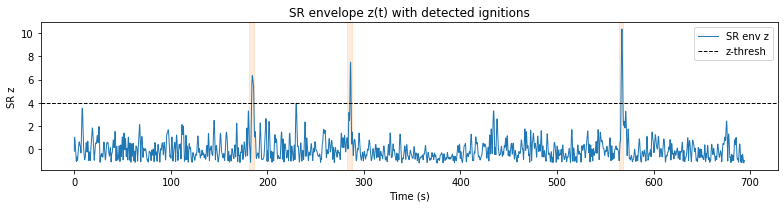

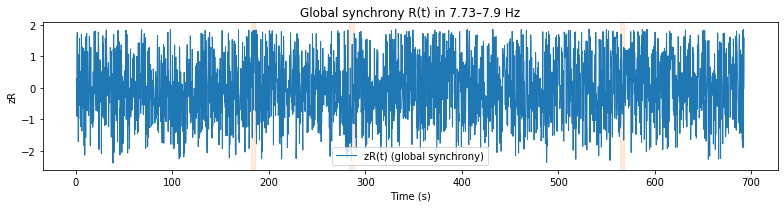

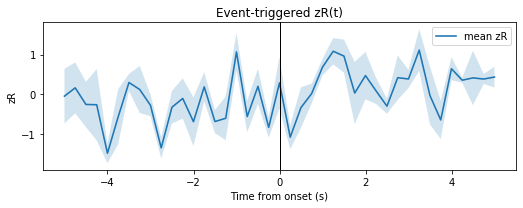

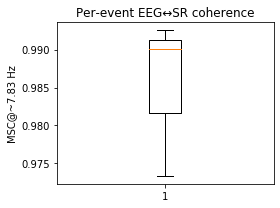


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=4.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 3
  zR max                 — median [IQR]: 7.51 [6.93, 8.94]
  zR peak (±5s)          — median [IQR]: 1.84 [1.77, 1.84]
  MSC@~7.83 Hz           — median [IQR]: 0.99 [0.98, 0.99]
  Coverage of recording  — 2.16%
  ETA zR peak            — 1.11 at 3.24s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max    zR_peak_±5s
 563.753263  568.753263  0.973273  10.364248   1.707421  
 282.934415  287.934415  0.990050   7.510944   1.841806  
 181.092238  186.092238  0.992633   6.345865   1.845733  

Files written to: exports_ignitions/S01
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)


In [10]:
ELECTRODES = [
    'EEG.AF3','EEG.AF4','EEG.F3','EEG.F7','EEG.F8','EEG.FC5','EEG.FC6',
    'EEG.P7','EEG.P8','EEG.T7','EEG.T8','EEG.O1','EEG.O2'
]

out = detect_ignitions_session(
    RECORDS,
    sr_channel='EEG.F4',
    eeg_channels=ELECTRODES,
    time_col=None,
    out_dir='exports_ignitions/S01',
    center_hz=7.83, half_bw_hz=0.4,
    z_thresh=4, min_isi_sec=3, window_sec=5,
    R_band=(7.73,7.9), R_win_sec=1, R_step_sec=0.25,
    eta_pre_sec=5, eta_post_sec=5,
    show=True,
    verbose=True     # <--- prints the summary block
)


## EPOC X


=== Processing test schumann_EPOCX_111270_2023.04.23T14.50.35.05.00.md.pm.bp ===


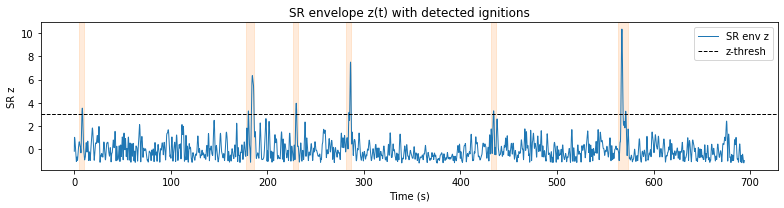

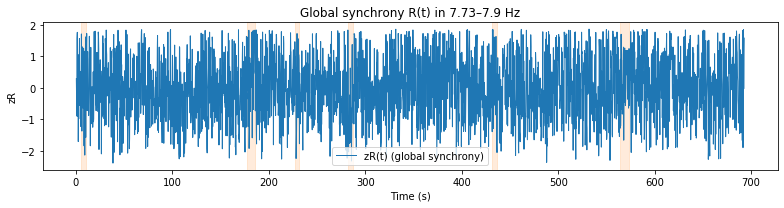

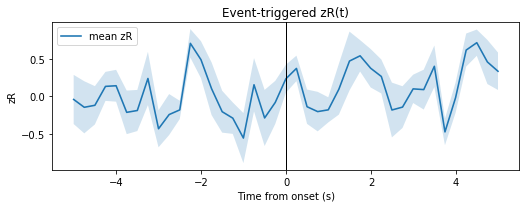

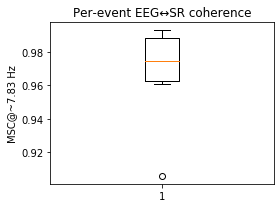


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 6
  zR max                 — median [IQR]: 5.15 [3.64, 7.22]
  zR peak (±5s)          — median [IQR]: 1.78 [1.73, 1.84]
  MSC@~7.83 Hz           — median [IQR]: 0.97 [0.96, 0.99]
  Coverage of recording  — 5.49%
  ETA zR peak            — 0.71 at 4.49s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max    zR_peak_±5s
 563.636165  573.399352  0.967728  10.364248   1.707421  
 281.888535  286.888535  0.993384   7.510944   1.841806  
 177.618346  185.913114  0.981734   6.345865   1.837899  
 226.856675  231.856675  0.990277   3.954905   1.730096  
   5.355367   10.355367  0.960763   3.528387   1.732097  
 431.515230  436.515230  0.905509   3.298561   1.854780  

Files written to: exports_ignitions_ba

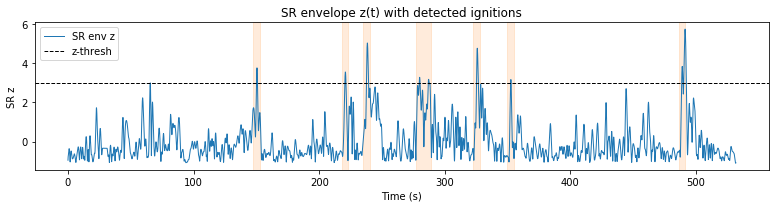

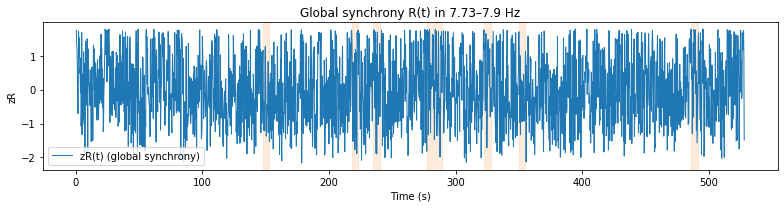

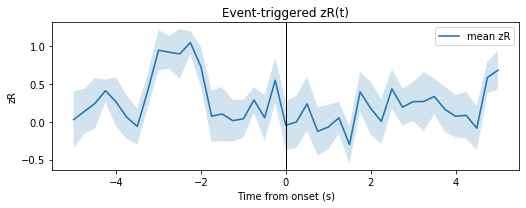

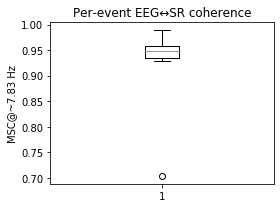


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 7
  zR max                 — median [IQR]: 3.77 [3.42, 4.90]
  zR peak (±5s)          — median [IQR]: 1.77 [1.76, 1.78]
  MSC@~7.83 Hz           — median [IQR]: 0.95 [0.94, 0.96]
  Coverage of recording  — 7.95%
  ETA zR peak            — 1.04 at -2.25s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 486.044989  491.044989  0.990026  5.746700   1.786010  
 235.076375  240.076375  0.941588  5.037691   1.768845  
 322.708154  327.708154  0.929095  4.768621   1.765334  
 147.577230  152.577230  0.947662  3.768219   1.764013  
 217.929158  222.929158  0.964021  3.555544   1.759412  
 277.100189  289.345839  0.951244  3.283676   1.782853  
 349.904166  354.904166  0.702601  3.172974  

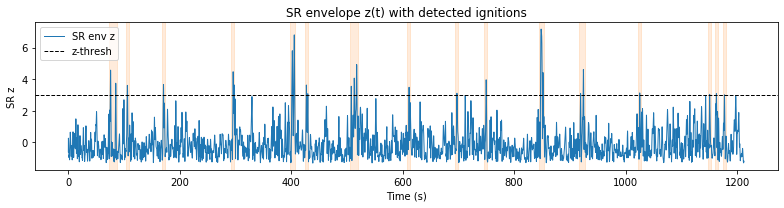

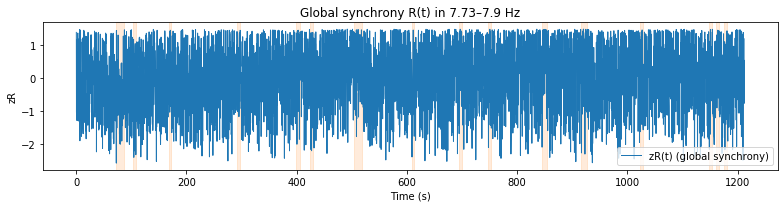

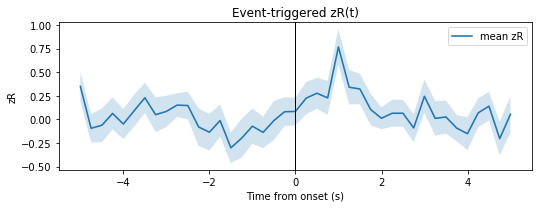

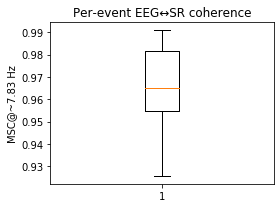


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 16
  zR max                 — median [IQR]: 3.65 [3.13, 4.58]
  zR peak (±5s)          — median [IQR]: 1.46 [1.45, 1.48]
  MSC@~7.83 Hz           — median [IQR]: 0.97 [0.95, 0.98]
  Coverage of recording  — 9.15%
  ETA zR peak            — 0.77 at 1.00s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max   zR_peak_±5s
  844.626036   853.717902  0.925407  7.167836   1.478744  
  398.439626   406.914165  0.988940  6.805122   1.453822  
  504.886202   519.031676  0.959654  4.925720   1.477779  
  916.491520   926.215995  0.968329  4.611690   1.488340  
   72.738886    87.170794  0.947810  4.572610   1.446582  
  292.716852   297.716852  0.980192  4.470500   1.451811  
  746.728736   751.728736  0.99

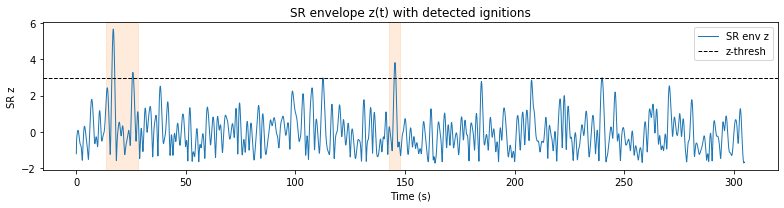

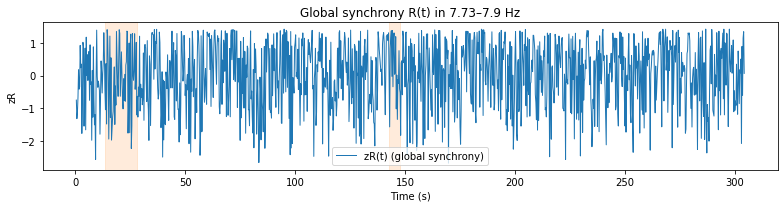

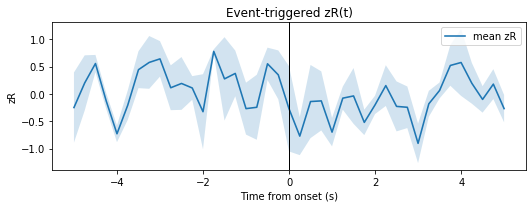

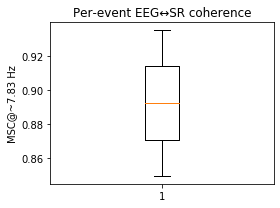


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 2
  zR max                 — median [IQR]: 4.75 [4.29, 5.21]
  zR peak (±5s)          — median [IQR]: 1.38 [1.38, 1.39]
  MSC@~7.83 Hz           — median [IQR]: 0.89 [0.87, 0.91]
  Coverage of recording  — 6.35%
  ETA zR peak            — 0.78 at -1.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83  zR_max   zR_peak_±5s
  13.687683   28.040792  0.849414  5.67614   1.396844  
 142.481891  147.481891  0.935205  3.82667   1.371457  

Files written to: exports_ignitions_batch/EPOCX
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing binaural_EPOCX_111270_2021.06.17T10.04.52.04.00.md.bp ===


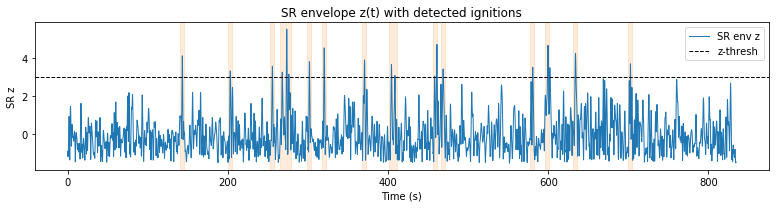

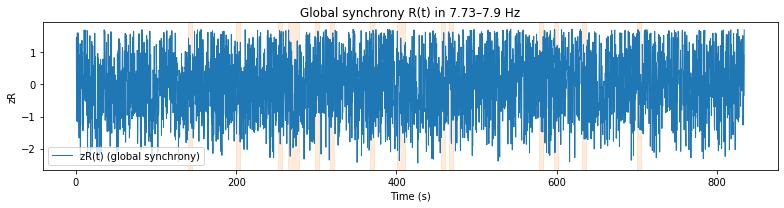

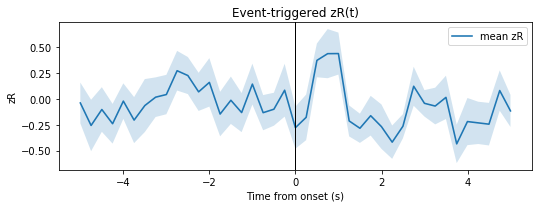

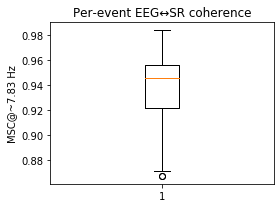


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 14
  zR max                 — median [IQR]: 3.85 [3.59, 4.46]
  zR peak (±5s)          — median [IQR]: 1.68 [1.65, 1.70]
  MSC@~7.83 Hz           — median [IQR]: 0.95 [0.92, 0.96]
  Coverage of recording  — 9.93%
  ETA zR peak            — 0.44 at 1.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 264.968265  278.221937  0.915872  5.521094   1.701283  
 455.501580  460.501580  0.866717  4.713365   1.619380  
 596.486454  601.486454  0.943959  4.664942   1.720252  
 317.141113  322.141113  0.955518  4.531315   1.695068  
 630.926385  635.926385  0.867343  4.247346   1.718346  
 139.952287  144.952287  0.970453  4.111783   1.447952  
 367.558815  372.558815  0.965961  3.897182  

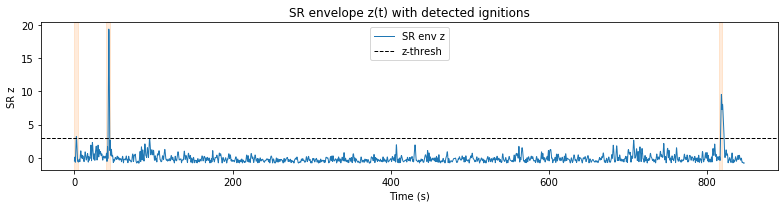

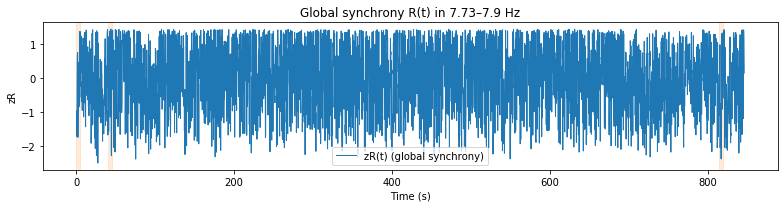

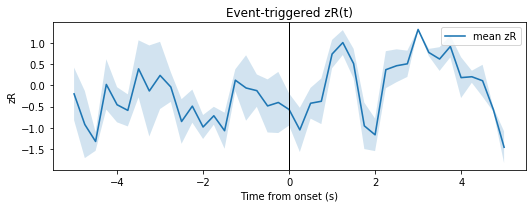

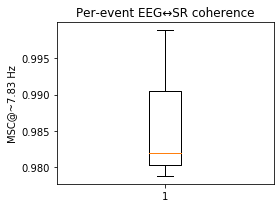


=== Ignition Detection — Session Summary ===
SR reference: EEG.F4
EEG channels (n=13): AF3, AF4, F3, F7, F8, FC5, FC6, P7, P8, T7, T8, O1, O2
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 3
  zR max                 — median [IQR]: 9.54 [6.37, 14.45]
  zR peak (±5s)          — median [IQR]: 1.44 [1.41, 1.45]
  MSC@~7.83 Hz           — median [IQR]: 0.98 [0.98, 0.99]
  Coverage of recording  — 1.74%
  ETA zR peak            — 1.32 at 3.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max    zR_peak_±5s
  40.017664   45.017664  0.998943  19.364239   1.454140  
 814.500316  819.500316  0.981928   9.543733   1.438515  
   0.000000    4.746563  0.978689   3.203645   1.384916  

Files written to: exports_ignitions_batch/EPOCX
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Batch complete ===
Master summ

In [11]:
ELECTRODES = [
    'EEG.AF3','EEG.AF4','EEG.F3','EEG.F7','EEG.F8','EEG.FC5','EEG.FC6',
    'EEG.P7','EEG.P8','EEG.T7','EEG.T8','EEG.O1','EEG.O2'
]


# ==========================================
# Batch ignition detection over many sessions
# ==========================================
import os
import pandas as pd
import numpy as np
import traceback

# 1) List your input files (CSV paths)
files = [
    'data/test schumann_EPOCX_111270_2023.04.23T14.50.35.05.00.md.pm.bp.csv',
    'data/Test_06.11.20_14.28.18.md.pm.bp.csv',
    'data/20201229_29.12.20_11.27.57.md.pm.bp.csv',
    'data/med_EPOCX_111270_2021.06.12T09.50.52.04.00.md.bp.csv',
    'data/binaural_EPOCX_111270_2021.06.17T10.04.52.04.00.md.bp.csv',   
    'data/hyp_02.01.21_13.51.16.md.pm.bp.csv'
    # 'data/Quality Assessment_MM_EPOCX_111270_2021.02.16T10.51.08.05.00.md.mc.pm.fe.bp.csv'
]

# 2) Output root for all sessions
ROOT_OUT = 'exports_ignitions_batch'
os.makedirs(ROOT_OUT, exist_ok=True)

# 4) Collect per-session summaries
master_rows = []

for fpath in files:
    records = load_eeg_csv(fpath, electrodes=ELECTRODES)
    # records = records.iloc[3840:-1920].reset_index(drop=True).copy()
    
    session_name = os.path.splitext(os.path.basename(fpath))[0]
    out_dir = os.path.join(ROOT_OUT, session_name)
    try:
        print(f"\n=== Processing {session_name} ===")

        out = detect_ignitions_session(records,
            sr_channel='EEG.F4',   # or your magnetometer channel
            eeg_channels=ELECTRODES,
            time_col=None,
            out_dir='exports_ignitions_batch/EPOCX',
            center_hz=7.83, half_bw_hz=0.4,
            z_thresh=3, min_isi_sec=3, window_sec=5,
            R_band=(7.73,7.9), R_win_sec=1, R_step_sec=0.25,
            eta_pre_sec=5, eta_post_sec=5,
            show=True, verbose=True     # <--- prints the summary block
        )
        
        # Store summary row
        summ = out['summary'].copy()
        summ['session'] = session_name[:30]+" ..."
        summ['n_events'] = summ.get('n_events', 0)
        master_rows.append(summ)

    except Exception as e:
        print(f"[ERROR] {session_name}: {e}")
        traceback.print_exc()
        # add a failed row so you keep the log complete
        master_rows.append({'session': session_name[:20]+" ...", 'n_events': np.nan, 'error': str(e)})

# 5) Save master summary across sessions
master_df = pd.DataFrame(master_rows)
master_csv = os.path.join(ROOT_OUT, 'master_ignition_summary-EPOCX.csv')
master_df.to_csv(master_csv, index=False)

print("\n=== Batch complete ===")
print("Master summary saved to:", master_csv)
print(master_df.fillna('').to_string(index=False))


## Insight


=== Processing testing_INSIGHT2_111270_2024.02.10T10.25.53.06.00.md.pm.bp ===


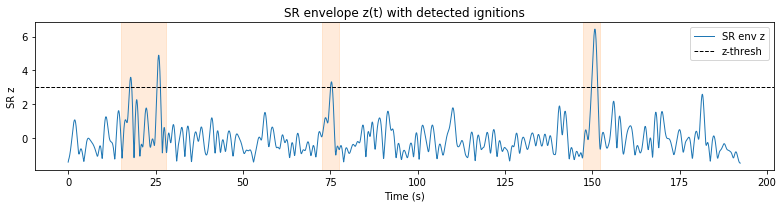

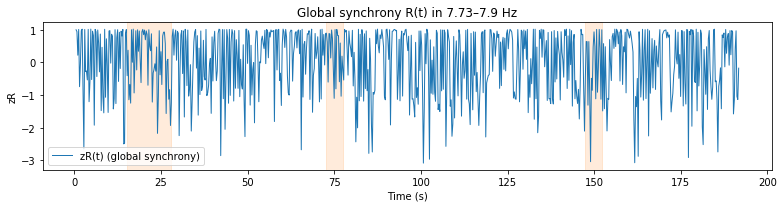

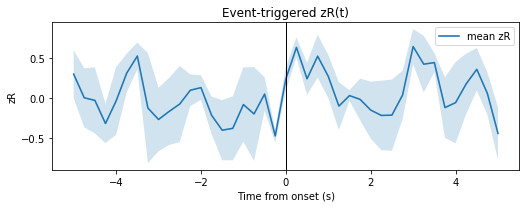

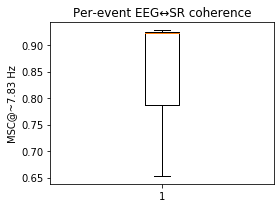


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 3
  zR max                 — median [IQR]: 4.90 [4.11, 5.67]
  zR peak (±5s)          — median [IQR]: 1.02 [1.02, 1.02]
  MSC@~7.83 Hz           — median [IQR]: 0.92 [0.79, 0.93]
  Coverage of recording  — 11.86%
  ETA zR peak            — 0.64 at 3.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 147.286045  152.286045  0.928997  6.437388   1.014472  
  15.064461   27.882170  0.652079  4.897447   1.020560  
  72.584365   77.584365  0.922285  3.327235   1.018172  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing shit_INSIGHT2_111270_2024.02.10T13.00.17.06.00.md.pm.bp ===


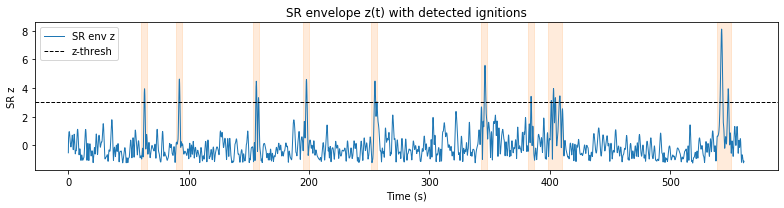

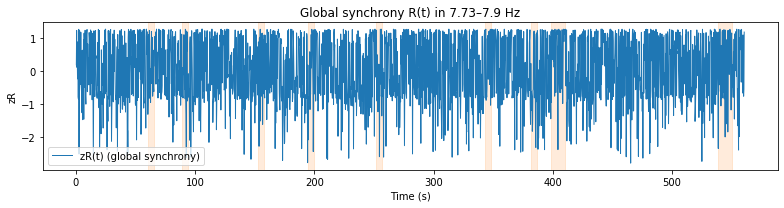

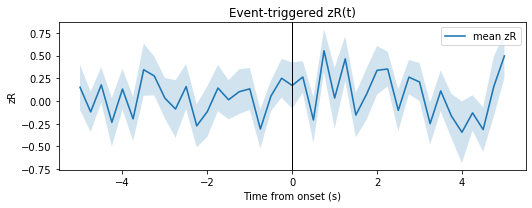

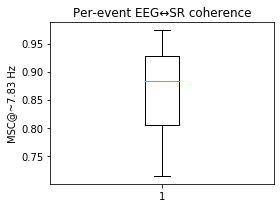


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 9
  zR max                 — median [IQR]: 4.49 [3.97, 4.63]
  zR peak (±5s)          — median [IQR]: 1.27 [1.27, 1.28]
  MSC@~7.83 Hz           — median [IQR]: 0.88 [0.81, 0.93]
  Coverage of recording  — 10.35%
  ETA zR peak            — 0.55 at 0.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 538.898333  550.200563  0.912623  8.122233   1.276670  
 342.974705  347.974705  0.882857  5.592491   1.273936  
  89.214249   94.214249  0.805339  4.633324   1.271731  
 194.774663  199.774663  0.713143  4.608800   1.268764  
 251.658739  256.658739  0.926962  4.493691   1.276071  
 153.204929  158.204929  0.955962  4.481684   1.271760  
 398.578031  410.341019  0.768189  3.972709   1.272603  
  60.412976   65.412976  0.

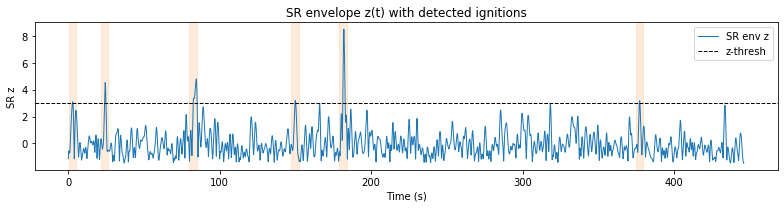

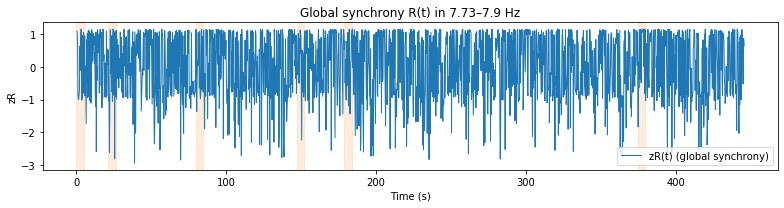

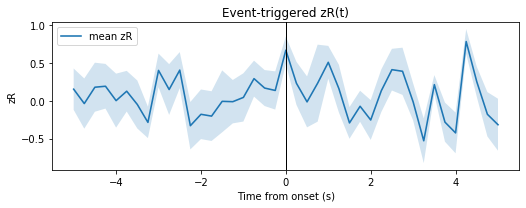

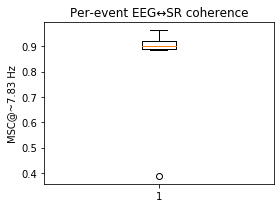


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 6
  zR max                 — median [IQR]: 3.87 [3.19, 4.73]
  zR peak (±5s)          — median [IQR]: 1.16 [1.16, 1.16]
  MSC@~7.83 Hz           — median [IQR]: 0.90 [0.89, 0.92]
  Coverage of recording  — 6.72%
  ETA zR peak            — 0.79 at 4.25s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 178.774719  183.774719  0.920723  8.503975   1.161735  
  79.972149   84.972149  0.386653  4.798024   1.154318  
  21.359130   26.359130  0.964559  4.527080   1.163012  
 147.176016  152.176016  0.886223  3.206260   1.151825  
 374.669501  379.669501  0.912189  3.178049   1.163430  
   0.178783    5.178783  0.889750  3.102341   1.157528  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png

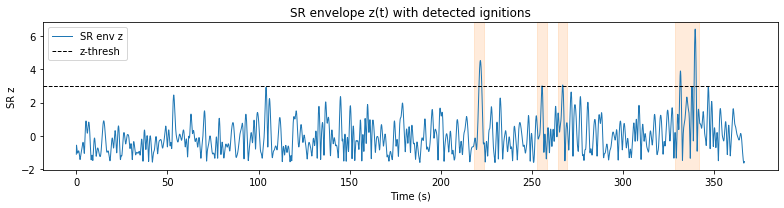

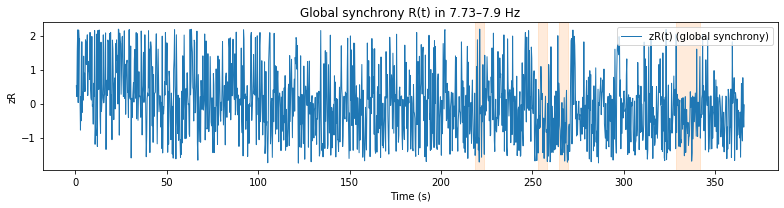

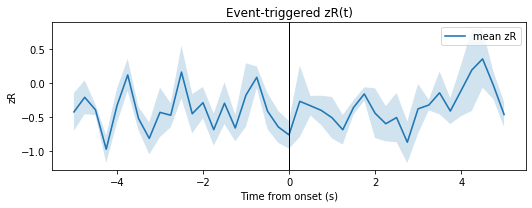

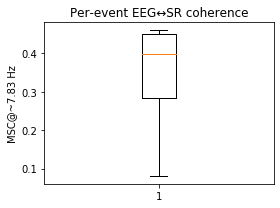


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 4
  zR max                 — median [IQR]: 3.79 [3.04, 5.00]
  zR peak (±5s)          — median [IQR]: 2.02 [1.92, 2.08]
  MSC@~7.83 Hz           — median [IQR]: 0.40 [0.28, 0.45]
  Coverage of recording  — 7.59%
  ETA zR peak            — 0.36 at 4.50s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 328.670047  341.487734  0.446966  6.410155   2.044036  
 218.457055  223.457055  0.461860  4.524123   2.192193  
 264.308846  269.308846  0.079586  3.056327   1.998399  
 253.047003  258.047003  0.351716  3.007378   1.672343  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing test

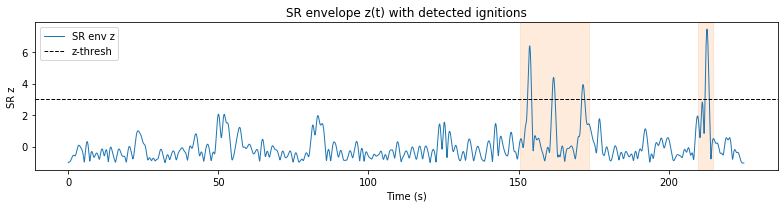

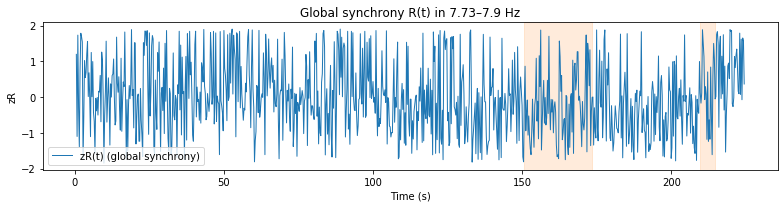

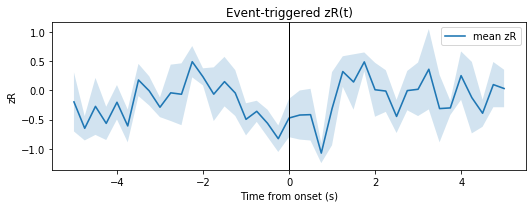

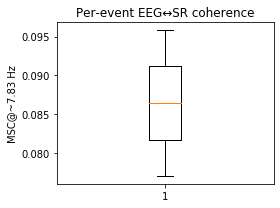


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 2
  zR max                 — median [IQR]: 6.93 [6.66, 7.19]
  zR peak (±5s)          — median [IQR]: 1.88 [1.88, 1.88]
  MSC@~7.83 Hz           — median [IQR]: 0.09 [0.08, 0.09]
  Coverage of recording  — 12.46%
  ETA zR peak            — 0.49 at -2.25s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 209.616425  214.616425  0.077011  7.461344   1.887235  
 150.472180  173.513010  0.095876  6.395523   1.876787  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing test_INSIGHT2_111270_2024.03.01T11.19.02.06.00.md.pm.bp ===


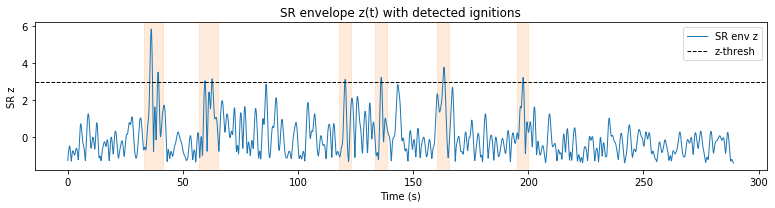

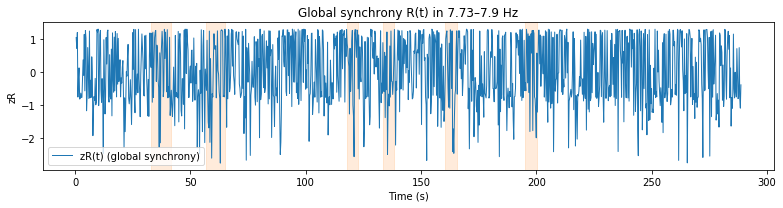

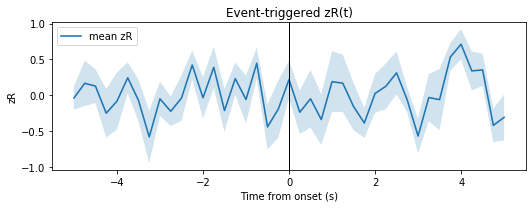

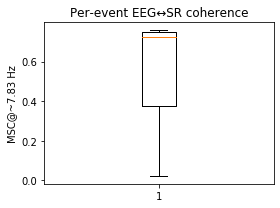


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 6
  zR max                 — median [IQR]: 3.23 [3.17, 3.64]
  zR peak (±5s)          — median [IQR]: 1.29 [1.29, 1.30]
  MSC@~7.83 Hz           — median [IQR]: 0.73 [0.38, 0.75]
  Coverage of recording  — 12.60%
  ETA zR peak            — 0.71 at 4.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
  33.050522   41.432195  0.726751  5.823011   1.297039  
 160.406047  165.406047  0.019563  3.772578   1.281404  
 133.446381  138.446381  0.759541  3.234391   1.293930  
 195.050624  200.050624  0.724376  3.226644   1.300306  
  56.964339   65.025807  0.761112  3.153761   1.283377  
 117.803215  122.803215  0.258831  3.119398   1.295220  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.pn

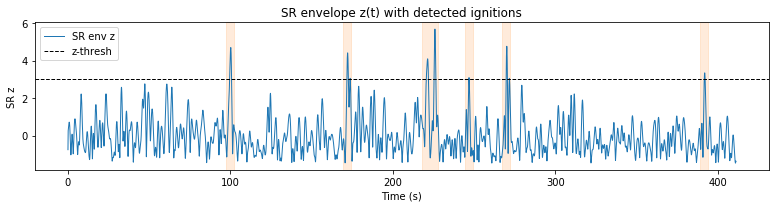

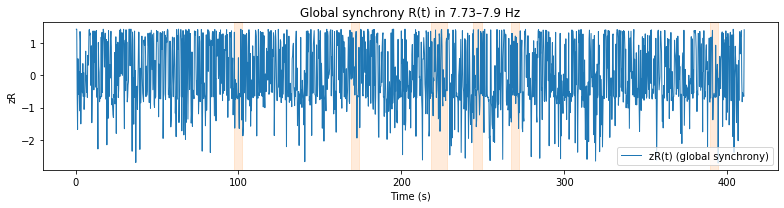

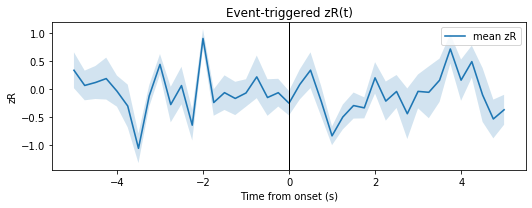

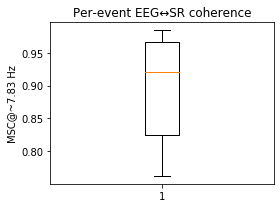


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 6
  zR max                 — median [IQR]: 4.55 [3.61, 4.74]
  zR peak (±5s)          — median [IQR]: 1.41 [1.39, 1.41]
  MSC@~7.83 Hz           — median [IQR]: 0.92 [0.82, 0.97]
  Coverage of recording  — 8.45%
  ETA zR peak            — 0.90 at -2.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 218.012167  227.744959  0.950192  5.672870   1.406411  
 267.159788  272.159788  0.985307  4.757232   1.367989  
  96.997964  101.997964  0.761516  4.691068   1.416243  
 169.130083  174.130083  0.972040  4.408270   1.413563  
 389.095558  394.095558  0.890198  3.342378   1.381861  
 244.175289  249.175289  0.802767  3.092262   1.414302  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.pn

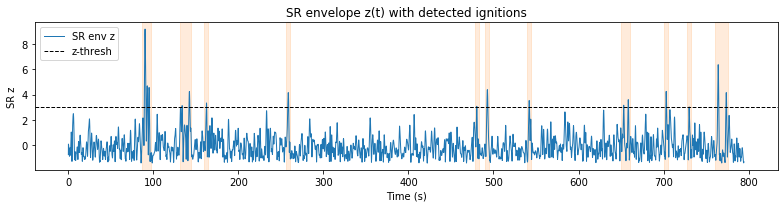

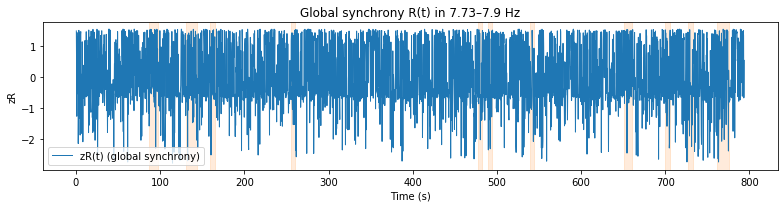

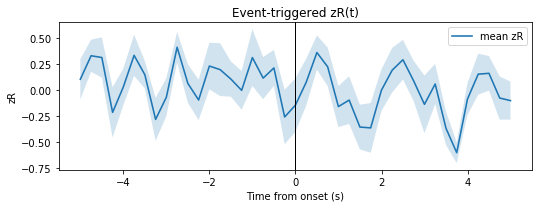

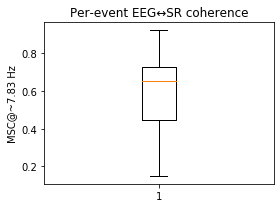


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 11
  zR max                 — median [IQR]: 4.15 [3.43, 4.32]
  zR peak (±5s)          — median [IQR]: 1.54 [1.53, 1.55]
  MSC@~7.83 Hz           — median [IQR]: 0.65 [0.45, 0.73]
  Coverage of recording  — 10.49%
  ETA zR peak            — 0.42 at -2.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
  86.821509   97.054124  0.707900  9.166390   1.550056  
 761.079024  775.825745  0.650418  6.357318   1.519911  
 489.662532  494.662532  0.924362  4.388282   1.537876  
 700.177640  705.177640  0.146952  4.246942   1.532876  
 131.150344  144.303851  0.344393  4.238764   1.494378  
 255.561610  260.561610  0.449969  4.154428   1.539686  
 650.499042  660.716037  0.831014  3.597728   1.540029  
 539.130263  544.130263  

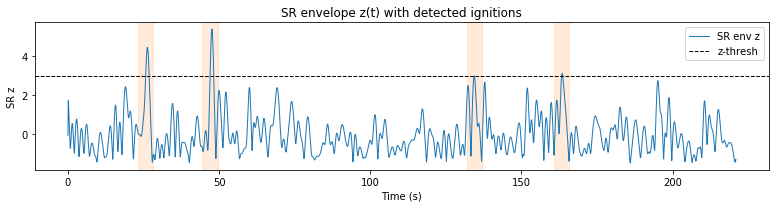

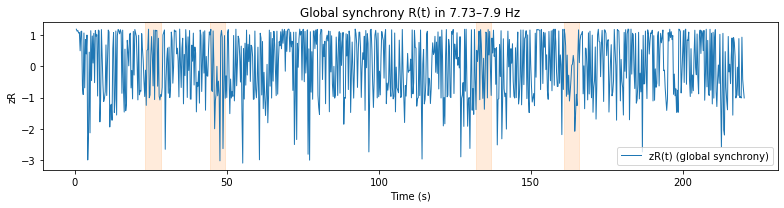

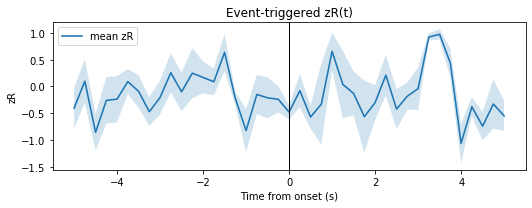

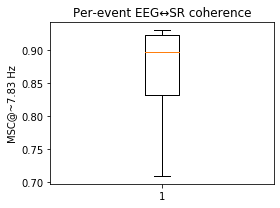


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 4
  zR max                 — median [IQR]: 3.80 [3.10, 4.71]
  zR peak (±5s)          — median [IQR]: 1.18 [1.18, 1.19]
  MSC@~7.83 Hz           — median [IQR]: 0.90 [0.83, 0.92]
  Coverage of recording  — 9.05%
  ETA zR peak            — 0.97 at 3.50s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
  44.491943   49.491943  0.920105  5.408503   1.183151  
  23.202257   28.202257  0.872736  4.472117   1.187550  
 160.772987  165.772987  0.708795  3.126752   1.185934  
 131.860876  136.860876  0.930537  3.000313   1.179706  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing test

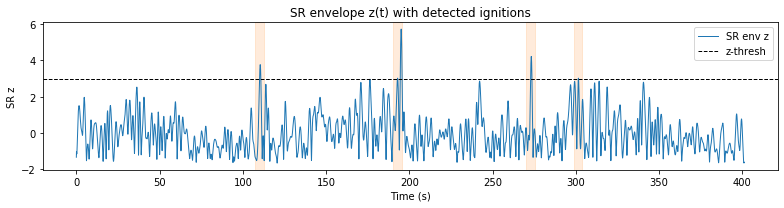

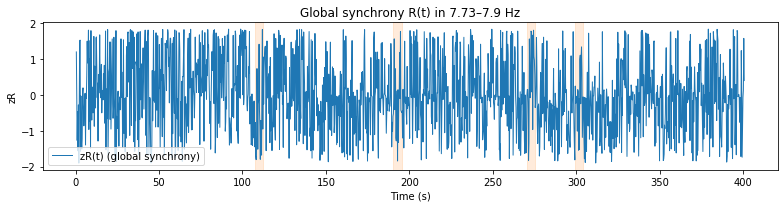

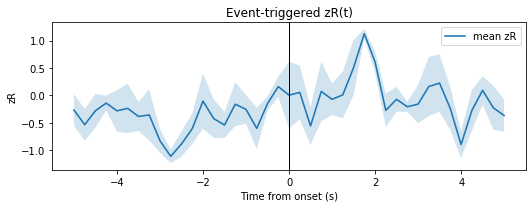

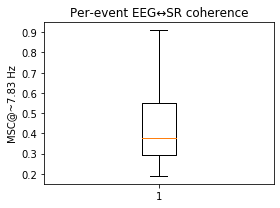


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 4
  zR max                 — median [IQR]: 3.99 [3.58, 4.59]
  zR peak (±5s)          — median [IQR]: 1.79 [1.77, 1.82]
  MSC@~7.83 Hz           — median [IQR]: 0.38 [0.29, 0.55]
  Coverage of recording  — 4.99%
  ETA zR peak            — 1.12 at 1.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 190.357096  195.357096  0.429637  5.722667   1.770705  
 270.330234  275.330234  0.912469  4.218674   1.811054  
 107.541163  112.541163  0.186948  3.768357   1.832098  
 298.969052  303.969052  0.328460  3.023658   1.769203  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing tet_

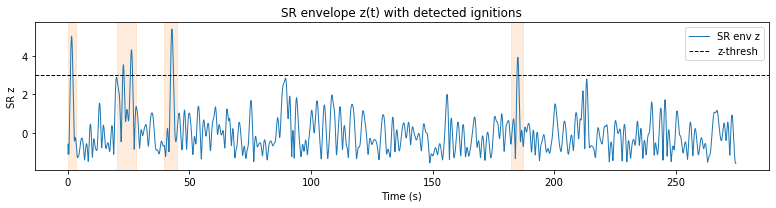

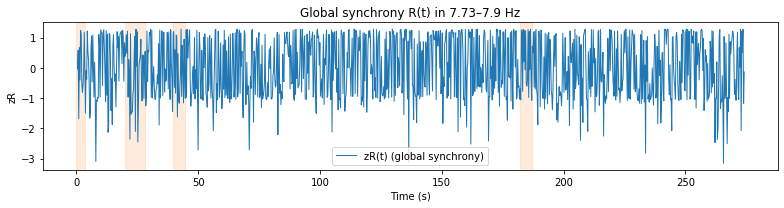

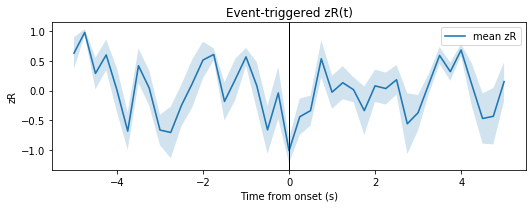

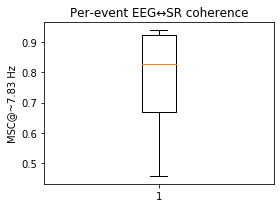


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 4
  zR max                 — median [IQR]: 4.13 [2.94, 4.59]
  zR peak (±5s)          — median [IQR]: 1.28 [1.27, 1.28]
  MSC@~7.83 Hz           — median [IQR]: 0.83 [0.67, 0.92]
  Coverage of recording  — 7.86%
  ETA zR peak            — 0.97 at -4.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
  39.673322   44.673322  0.941334  5.402623   1.283085  
  20.031488   28.139818  0.454923  4.325435   1.281163  
 182.242583  187.242583  0.739865  3.933268   1.283343  
   0.000000    3.476234  0.918317 -0.019855   1.239704  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing tes

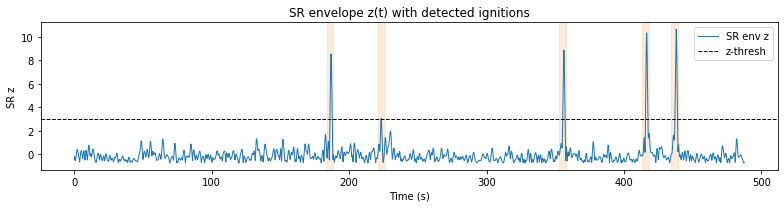

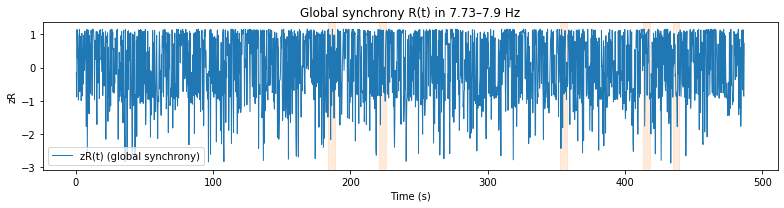

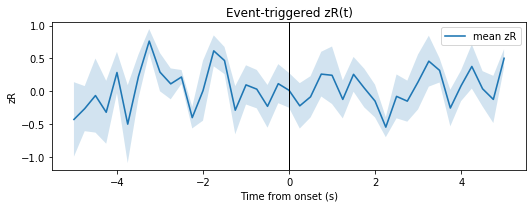

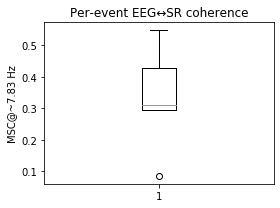


=== Ignition Detection — Session Summary ===
SR reference: EEG.Pz
EEG channels (n=4): AF3, AF4, T7, T8
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 5
  zR max                 — median [IQR]: 8.87 [8.56, 10.35]
  zR peak (±5s)          — median [IQR]: 1.16 [1.15, 1.16]
  MSC@~7.83 Hz           — median [IQR]: 0.31 [0.29, 0.43]
  Coverage of recording  — 5.13%
  ETA zR peak            — 0.76 at -3.25s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max    zR_peak_±5s
 434.626619  439.626619  0.309368  10.665733   1.137023  
 413.219747  418.219747  0.083374  10.350491   1.160369  
 352.966546  357.966546  0.292963   8.869707   1.153130  
 183.546887  188.546887  0.427654   8.557577   1.161403  
 220.714091  225.714091  0.549250   3.076882   1.160108  

Files written to: exports_ignitions_batch/Insight
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (

In [12]:
INSIGHT_ELECTRODES = ['EEG.AF3','EEG.AF4','EEG.T7','EEG.T8']

# ==========================================
# Batch ignition detection over many sessions
# ==========================================
import os
import pandas as pd
import numpy as np
import traceback

# 1) List your input files (CSV paths)
files = [
    'data/testing_INSIGHT2_111270_2024.02.10T10.25.53.06.00.md.pm.bp.csv',
    'data/shit_INSIGHT2_111270_2024.02.10T13.00.17.06.00.md.pm.bp.csv',
    'data/testing_INSIGHT2_111270_2024.02.12T10.25.21.06.00.md.pm.bp.csv',
    'data/testing_INSIGHT2_111270_2024.02.13T08.26.34.06.00.md.pm.bp.csv',
    'data/testing_INSIGHT2_111270_2024.02.15T11.43.15.06.00.md.pm.bp.csv',
    'data/test_INSIGHT2_111270_2024.03.01T11.19.02.06.00.md.pm.bp.csv',
    'data/test_INSIGHT2_111270_2024.03.02T10.03.06.06.00.md.pm.bp.csv',
    'data/test_INSIGHT2_111270_2024.03.02T10.17.57.06.00.bp.csv',
    'data/test_INSIGHT2_111270_2024.03.05T07.14.31.06.00.md.pm.bp.csv',
    'data/test_INSIGHT2_111270_2024.03.05T07.02.55.06.00.bp.csv',
    'data/tet_INSIGHT2_111270_2024.03.05T07.49.33.06.00.md.pm.bp.csv',
    'data/test_INSIGHT2_111270_2024.03.08T12.26.06.06.00.md.pm.bp.csv'
]

# 2) Output root for all sessions
ROOT_OUT = 'exports_ignitions_batch'
os.makedirs(ROOT_OUT, exist_ok=True)

# 4) Collect per-session summaries
master_rows = []

for fpath in files:
    records = load_eeg_csv(fpath, electrodes=INSIGHT_ELECTRODES)
    records = records.iloc[3840:-1920].reset_index(drop=True).copy()
    
    session_name = os.path.splitext(os.path.basename(fpath))[0]
    out_dir = os.path.join(ROOT_OUT, session_name)
    try:
        print(f"\n=== Processing {session_name} ===")

        out = detect_ignitions_session(
            records,
            sr_channel='EEG.Pz',   # or your magnetometer channel
            eeg_channels=INSIGHT_ELECTRODES,
            time_col=None,
            out_dir='exports_ignitions_batch/Insight',
            center_hz=7.83, half_bw_hz=0.4,
            z_thresh=3, min_isi_sec=3, window_sec=5,
            R_band=(7.73,7.9), R_win_sec=1, R_step_sec=0.25,
            eta_pre_sec=5, eta_post_sec=5,
            show=True,
            verbose=True     # <--- prints the summary block
        )

        # Store summary row
        summ = out['summary'].copy()
        summ['session'] = session_name[:30]+" ..."
        summ['n_events'] = summ.get('n_events', 0)
        master_rows.append(summ)

    except Exception as e:
        print(f"[ERROR] {session_name}: {e}")
        traceback.print_exc()
        # add a failed row so you keep the log complete
        master_rows.append({'session': session_name[:20]+" ...", 'n_events': np.nan, 'error': str(e)})

# 5) Save master summary across sessions
master_df = pd.DataFrame(master_rows)
master_csv = os.path.join(ROOT_OUT, 'master_ignition_summary-INSIGHT.csv')
master_df.to_csv(master_csv, index=False)

print("\n=== Batch complete ===")
print("Master summary saved to:", master_csv)
print(master_df.fillna('').to_string(index=False))


## Muse


=== Processing Muse-461E_2019-11-28--16-01-03_1575083390915 ===


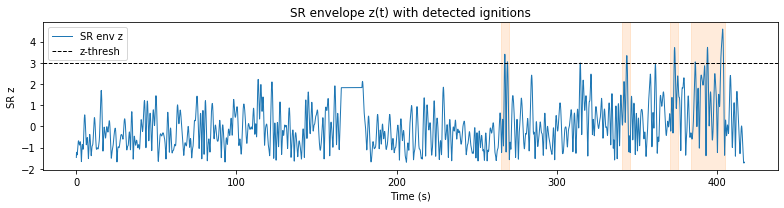

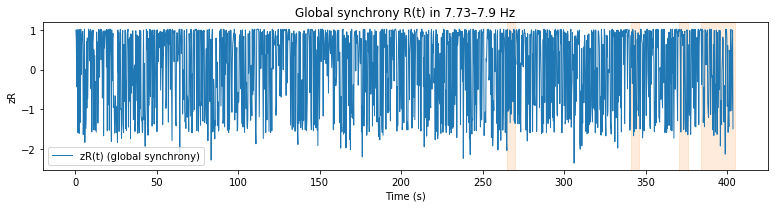

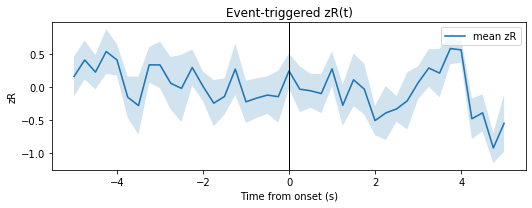

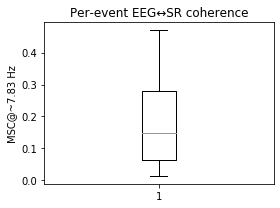


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 4
  zR max                 — median [IQR]: 3.56 [3.39, 3.94]
  zR peak (±5s)          — median [IQR]: 1.02 [1.02, 1.02]
  MSC@~7.83 Hz           — median [IQR]: 0.15 [0.07, 0.28]
  Coverage of recording  — 8.63%
  ETA zR peak            — 0.58 at 3.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 383.864448  404.872208  0.082931  4.589460   1.020223  
 370.719261  375.719261  0.216142  3.719778   1.019925  
 264.854817  269.854817  0.012281  3.404214   1.013778  
 340.964901  345.964901  0.471605  3.341800   1.020018  

Files written to: exports_ignitions_batch/S01
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing Muse-461E

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


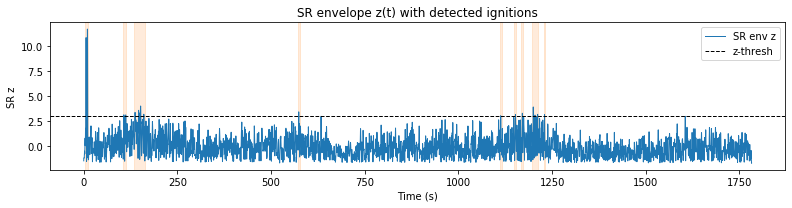

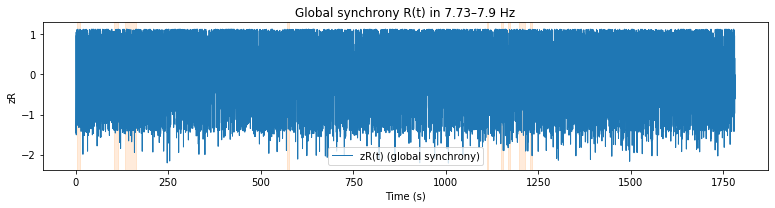

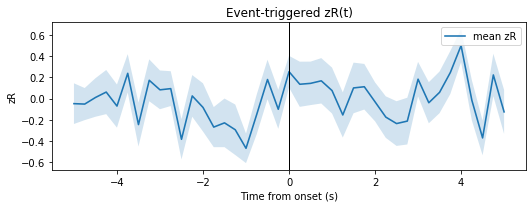

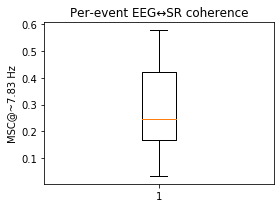


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 9
  zR max                 — median [IQR]: 3.28 [3.14, 3.91]
  zR peak (±5s)          — median [IQR]: 1.13 [1.12, 1.13]
  MSC@~7.83 Hz           — median [IQR]: 0.25 [0.17, 0.42]
  Coverage of recording  — 4.90%
  ETA zR peak            — 0.50 at 4.00s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max    zR_peak_±5s
    3.049964    11.264334  0.172510  11.722518   1.128740  
  134.042389   162.632665  0.030363   4.008389   1.131493  
 1196.924903  1213.759098  0.066261   3.914556   1.123760  
  571.020997   576.020997  0.483119   3.421258   1.127724  
 1167.940892  1172.940892  0.272756   3.283760   1.124037  
 1149.549069  1154.549069  0.168680   3.156787   1.128164  
 1227.135298  1232.135298  0.422854   3.141047   1.130161  
  104

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


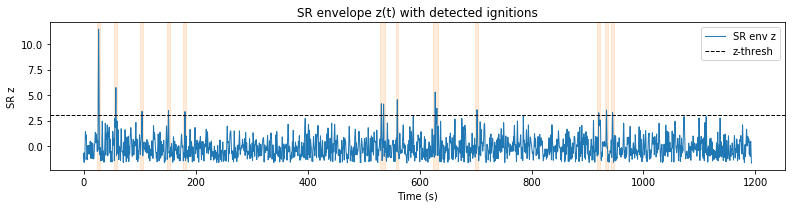

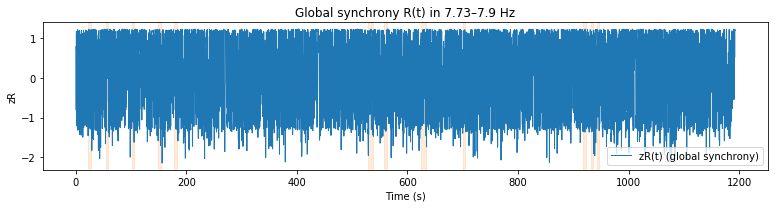

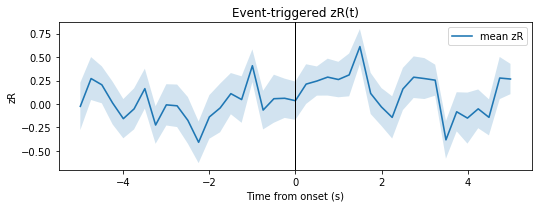

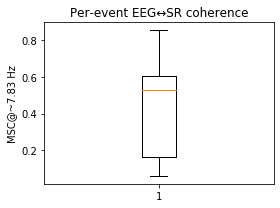


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 12
  zR max                 — median [IQR]: 3.55 [3.40, 4.73]
  zR peak (±5s)          — median [IQR]: 1.23 [1.22, 1.23]
  MSC@~7.83 Hz           — median [IQR]: 0.53 [0.16, 0.61]
  Coverage of recording  — 5.65%
  ETA zR peak            — 0.61 at 1.50s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max    zR_peak_±5s
  23.223853   28.223853  0.857980  11.456519   1.228409  
  54.200262   59.200262  0.597330   5.731462   1.230788  
 624.834759  633.037061  0.167506   5.283690   1.224233  
 557.266199  562.266199  0.535192   4.545729   1.231506  
 528.675895  537.858413  0.152508   4.157254   1.232013  
 699.835002  704.835002  0.056237   3.561700   1.216346  
 931.130988  936.130988  0.637357   3.530134   1.217277  
 148.629102  153.629

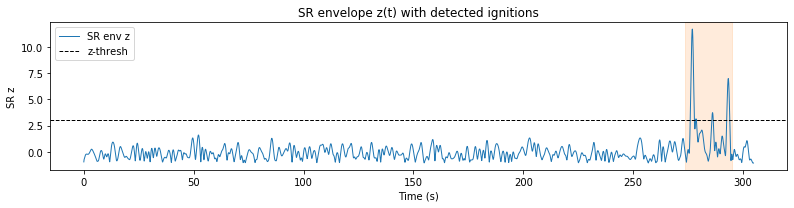

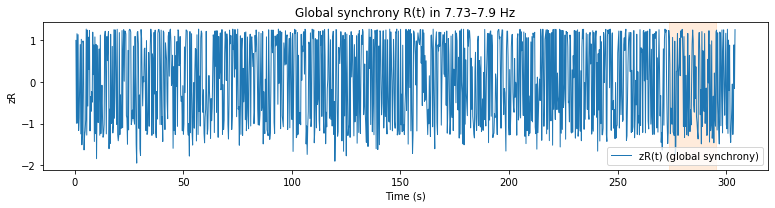

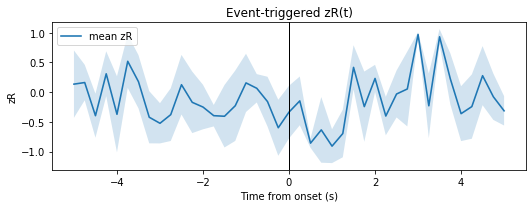

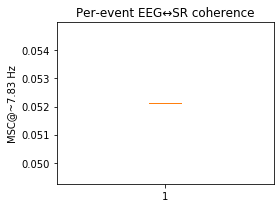


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 1
  zR max                 — median [IQR]: 11.69 [11.69, 11.69]
  zR peak (±5s)          — median [IQR]: 1.26 [1.26, 1.26]
  MSC@~7.83 Hz           — median [IQR]: 0.05 [0.05, 0.05]
  Coverage of recording  — 7.09%
  ETA zR peak            — 0.97 at 3.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max    zR_peak_±5s
 273.502224  295.103539  0.052121  11.688993   1.257563  

Files written to: exports_ignitions_batch/S01
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing Muse-461E_2019-12-03--20-53-25_1575436553405 ===


/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


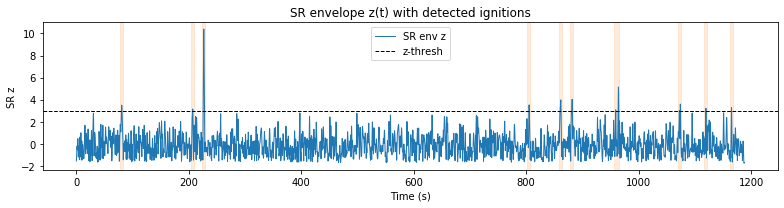

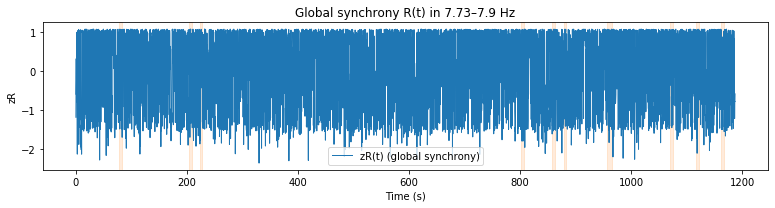

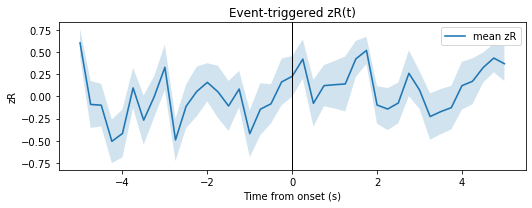

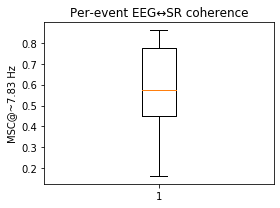


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 10
  zR max                 — median [IQR]: 3.56 [3.34, 4.02]
  zR peak (±5s)          — median [IQR]: 1.08 [1.08, 1.08]
  MSC@~7.83 Hz           — median [IQR]: 0.57 [0.45, 0.78]
  Coverage of recording  — 4.57%
  ETA zR peak            — 0.60 at -5.00s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max    zR_peak_±5s
  223.041470   228.041470  0.863863  10.393092   1.077528  
  956.558941   965.831388  0.775056   5.154865   1.075550  
  878.557490   883.557490  0.206188   4.027829   1.079678  
  857.874785   862.874785  0.613366   3.983171   1.078190  
 1069.798317  1074.798317  0.778096   3.596234   1.072881  
  802.282202   807.282202  0.454071   3.527400   1.080107  
   77.649390    82.649390  0.534656   3.505701   1.079588  
 11

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


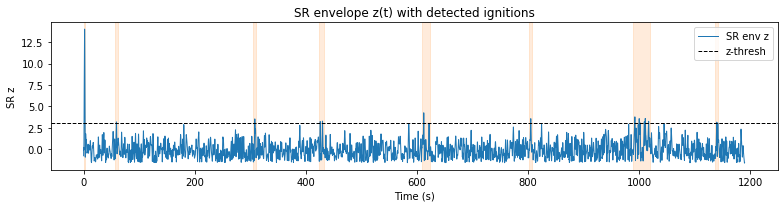

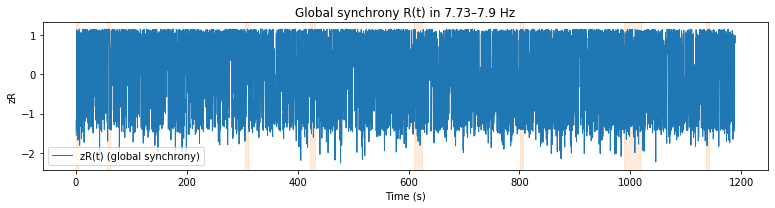

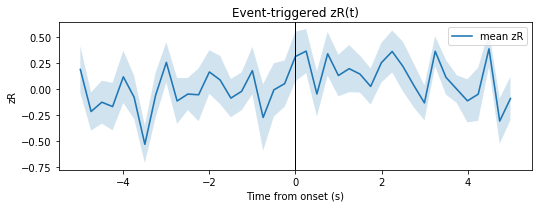

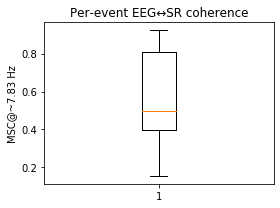


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 8
  zR max                 — median [IQR]: 3.55 [3.25, 3.89]
  zR peak (±5s)          — median [IQR]: 1.14 [1.14, 1.14]
  MSC@~7.83 Hz           — median [IQR]: 0.50 [0.40, 0.81]
  Coverage of recording  — 6.50%
  ETA zR peak            — 0.39 at 4.50s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max   zR_peak_±5s
    0.000000     3.320122  0.916843  5.659920   1.141206  
  609.236721   624.132859  0.435273  4.246321   1.139293  
  989.132798  1019.111367  0.152022  3.771903   1.139716  
  801.945836   806.945836  0.287762  3.561531   1.137403  
  305.299552   310.299552  0.926221  3.534202   1.142213  
  423.123729   432.197001  0.480551  3.272238   1.142676  
   56.345697    61.345697  0.774195  3.185901   1.141528  
 1136.817222 

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


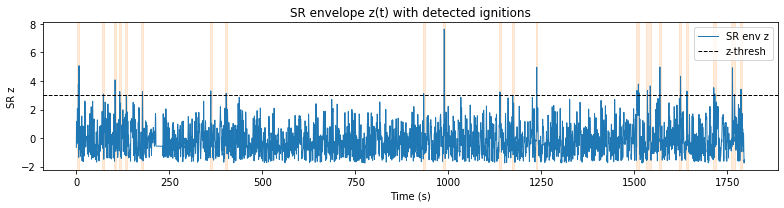

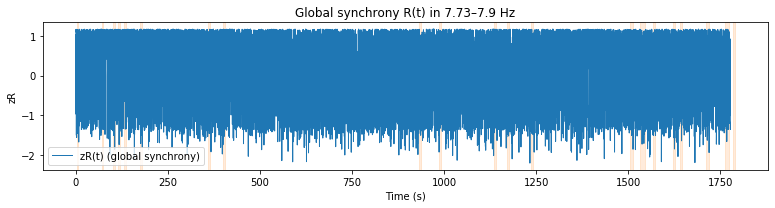

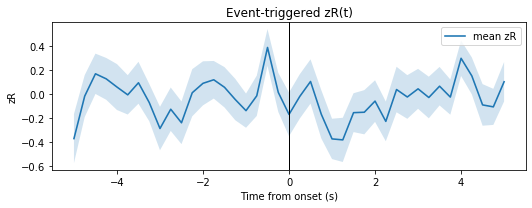

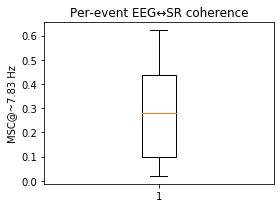


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 21
  zR max                 — median [IQR]: 3.43 [3.24, 4.34]
  zR peak (±5s)          — median [IQR]: 1.17 [1.17, 1.17]
  MSC@~7.83 Hz           — median [IQR]: 0.28 [0.10, 0.44]
  Coverage of recording  — 6.97%
  ETA zR peak            — 0.39 at -0.50s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max   zR_peak_±5s
  986.072501   991.072501  0.217580  7.637106   1.163595  
    2.511162     7.511162  0.531100  5.076025   1.171091  
 1566.080242  1571.080242  0.017661  4.985478   1.163469  
 1234.906683  1239.906683  0.624178  4.962434   1.167776  
 1761.217886  1772.236241  0.238851  4.924173   1.171037  
 1621.788104  1626.788104  0.328395  4.339768   1.170408  
  101.195508   106.195508  0.470878  4.079977   1.170233  
 1504.93594

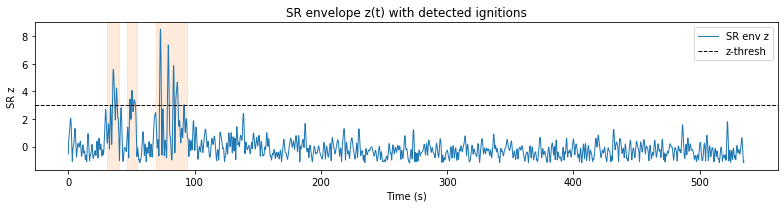

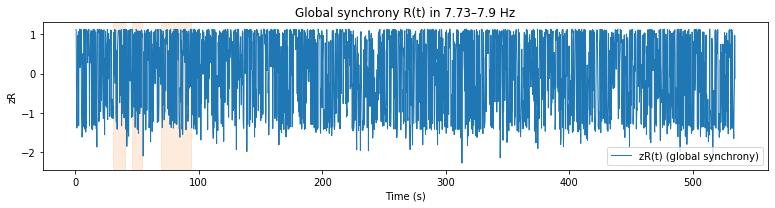

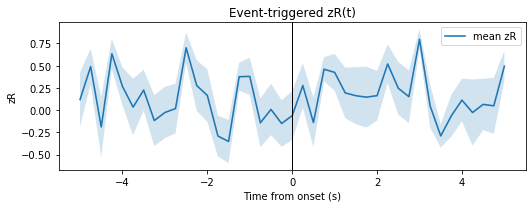

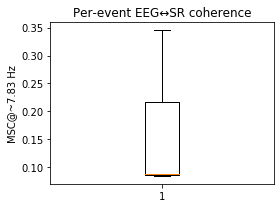


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 3
  zR max                 — median [IQR]: 5.60 [4.83, 7.06]
  zR peak (±5s)          — median [IQR]: 1.13 [1.13, 1.13]
  MSC@~7.83 Hz           — median [IQR]: 0.09 [0.09, 0.22]
  Coverage of recording  — 7.78%
  ETA zR peak            — 0.80 at 3.00s

Events by MSC@~7.83 Hz:
  t_start     t_end    msc_7p83   zR_max   zR_peak_±5s
 69.658125  93.974756  0.087856  8.514739   1.130955  
 30.923318  40.117831  0.346342  5.596709   1.131388  
 46.064964  54.181558  0.083363  4.068429   1.136749  

Files written to: exports_ignitions_batch/S01
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing Muse-461E_2019-12-06--20-54-24_1575694700892 ===


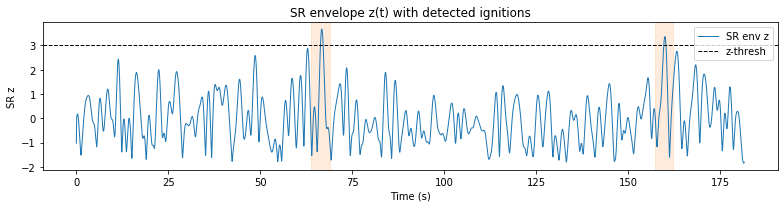

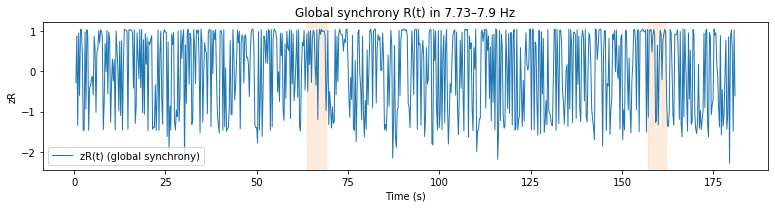

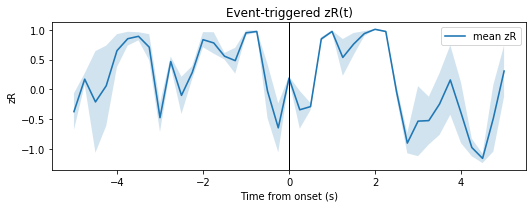

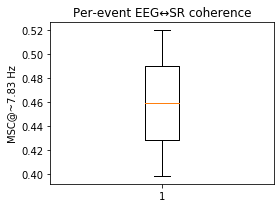


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 2
  zR max                 — median [IQR]: 3.52 [3.44, 3.60]
  zR peak (±5s)          — median [IQR]: 1.05 [1.05, 1.05]
  MSC@~7.83 Hz           — median [IQR]: 0.46 [0.43, 0.49]
  Coverage of recording  — 5.51%
  ETA zR peak            — 1.01 at 2.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
  63.842979   68.842979  0.520600  3.673191   1.053019  
 157.153538  162.153538  0.397828  3.365951   1.049516  

Files written to: exports_ignitions_batch/S01
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing Muse-461E_2019-12-06--20-57-59_1575694836983 ===


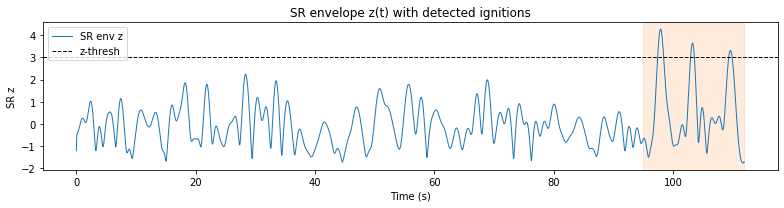

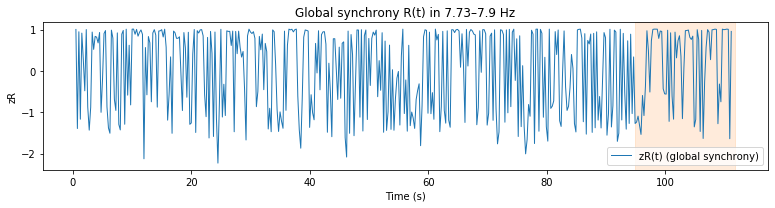

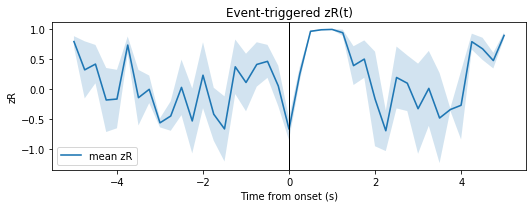

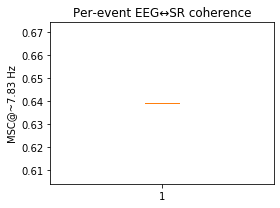


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 1
  zR max                 — median [IQR]: 4.28 [4.28, 4.28]
  zR peak (±5s)          — median [IQR]: 1.01 [1.01, 1.01]
  MSC@~7.83 Hz           — median [IQR]: 0.64 [0.64, 0.64]
  Coverage of recording  — 15.11%
  ETA zR peak            — 1.00 at 1.00s

Events by MSC@~7.83 Hz:
  t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 94.909864  111.825492  0.639044  4.277568   1.009847  

Files written to: exports_ignitions_batch/S01
  - sr_env_z.png, R_timeseries.png, ETA_zR.png, events_msc_box.png
  - events.csv (per event) and summary.csv (session summary)

=== Processing Muse-461E_2019-12-06--21-00-26_1575696038038 ===


/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


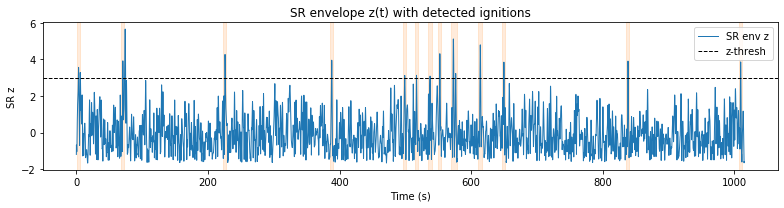

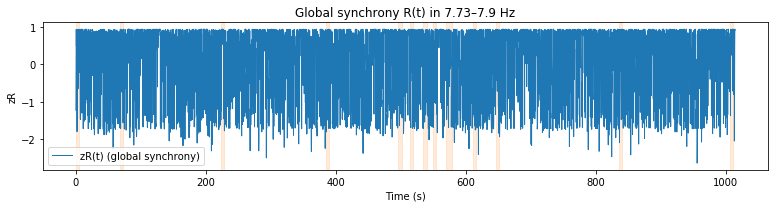

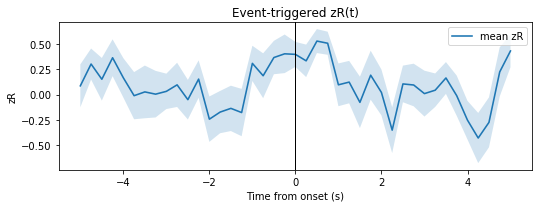

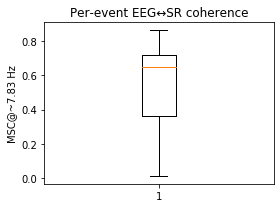


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 13
  zR max                 — median [IQR]: 3.90 [3.56, 4.31]
  zR peak (±5s)          — median [IQR]: 0.94 [0.94, 0.95]
  MSC@~7.83 Hz           — median [IQR]: 0.65 [0.36, 0.72]
  Coverage of recording  — 6.79%
  ETA zR peak            — 0.53 at 0.50s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max   zR_peak_±5s
   67.818871    72.818871  0.428364  5.650553   0.944728  
  569.830937   578.795260  0.545019  5.112281   0.939735  
  610.880223   615.880223  0.654524  4.788950   0.941263  
  549.482053   554.482053  0.719237  4.305471   0.943750  
  223.032822   228.032822  0.827366  4.266686   0.945056  
  385.179454   390.179454  0.648868  3.951526   0.943105  
  835.542066   840.542066  0.708184  3.902530   0.945226  
 1006.761723

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


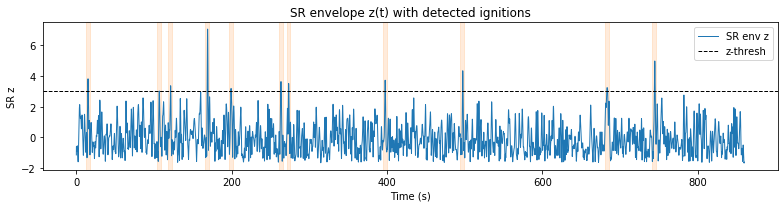

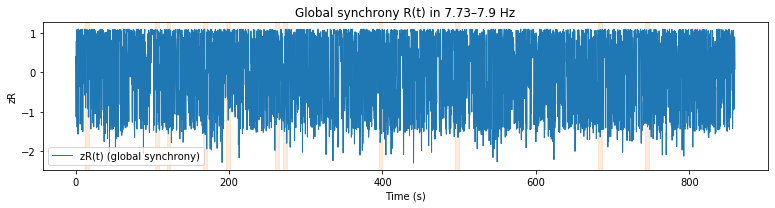

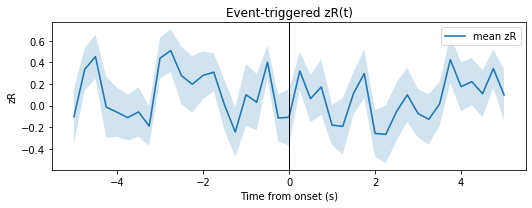

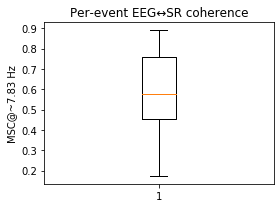


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 11
  zR max                 — median [IQR]: 3.65 [3.31, 4.09]
  zR peak (±5s)          — median [IQR]: 1.10 [1.09, 1.10]
  MSC@~7.83 Hz           — median [IQR]: 0.58 [0.45, 0.76]
  Coverage of recording  — 6.39%
  ETA zR peak            — 0.51 at -2.75s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
 165.869472  170.869472  0.846279  7.068681   1.097783  
 741.836793  746.836793  0.646622  4.987381   1.096548  
 494.676188  499.676188  0.673686  4.349291   1.096194  
  12.118579   17.118579  0.886036  3.824495   1.097066  
 394.798839  399.798839  0.567778  3.731422   1.096720  
 260.556308  265.556308  0.892847  3.647738   1.089440  
 270.656133  275.656133  0.569955  3.514892   1.095603  
 118.635411  123.635411  0.

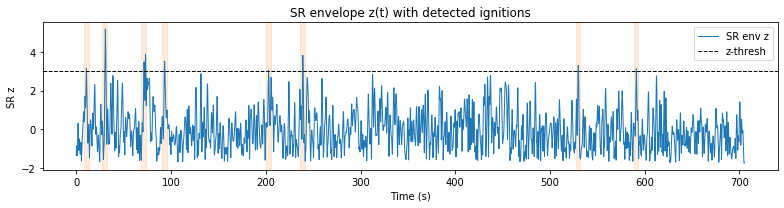

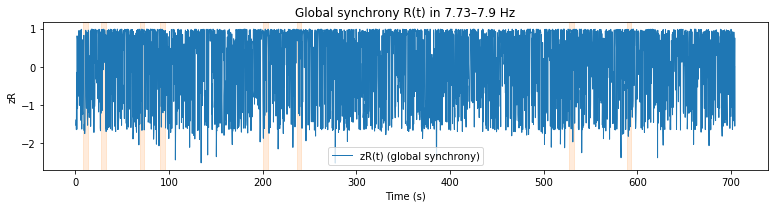

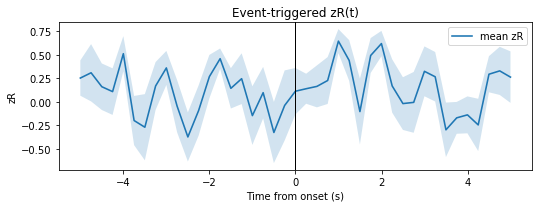

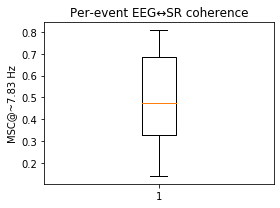


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 8
  zR max                 — median [IQR]: 3.41 [3.16, 3.84]
  zR peak (±5s)          — median [IQR]: 0.98 [0.98, 0.99]
  MSC@~7.83 Hz           — median [IQR]: 0.48 [0.33, 0.69]
  Coverage of recording  — 5.67%
  ETA zR peak            — 0.64 at 1.00s

Events by MSC@~7.83 Hz:
   t_start      t_end    msc_7p83   zR_max   zR_peak_±5s
  27.542113   32.542113  0.705125  5.188759   0.983587  
  68.643533   73.643533  0.196472  3.896493   0.985402  
 236.247513  241.247513  0.371033  3.826570   0.981411  
  90.332587   95.332587  0.810190  3.519065   0.985581  
 527.085463  532.085463  0.501570  3.303500   0.985862  
   7.918869   12.918869  0.138112  3.164836   0.980312  
 588.419327  593.419327  0.681438  3.133354   0.985872  
 200.277423  205.277423  0.44

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


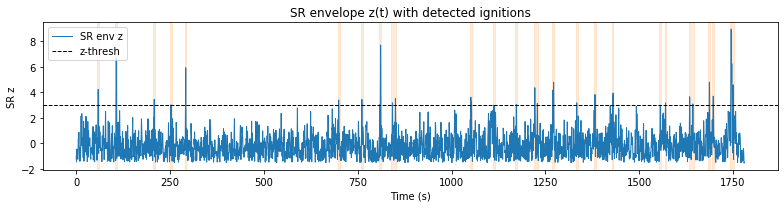

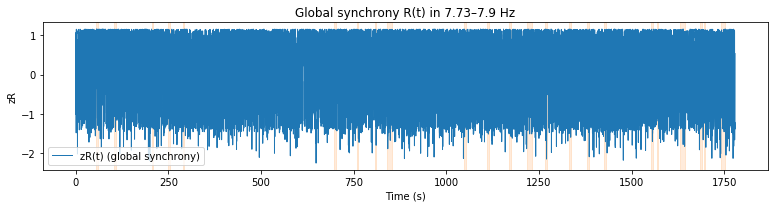

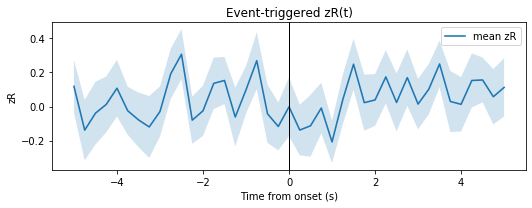

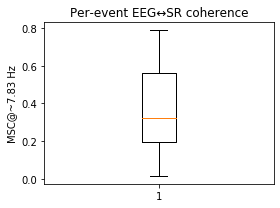


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 23
  zR max                 — median [IQR]: 3.66 [3.30, 4.59]
  zR peak (±5s)          — median [IQR]: 1.16 [1.16, 1.16]
  MSC@~7.83 Hz           — median [IQR]: 0.32 [0.19, 0.56]
  Coverage of recording  — 8.14%
  ETA zR peak            — 0.31 at -2.50s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max   zR_peak_±5s
 1741.355965  1752.363147  0.407240  8.966700   1.147767  
  806.520525   811.520525  0.334036  7.715765   1.157215  
  102.938148   107.938148  0.365492  6.682276   1.160178  
  288.266346   293.266346  0.771951  5.937264   1.160327  
 1266.823758  1271.823758  0.318885  4.806330   1.161403  
 1683.944025  1688.944025  0.725755  4.806240   1.156204  
 1218.715528  1230.953049  0.230605  4.373035   1.158674  
   55.15410

/home/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:235: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/michael/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


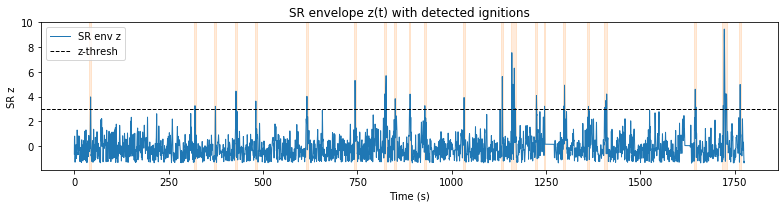

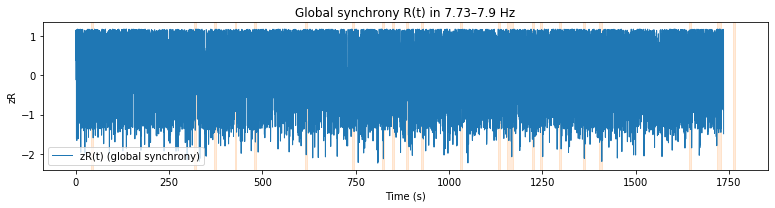

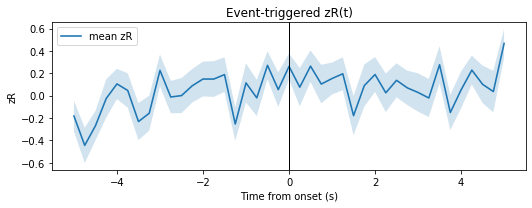

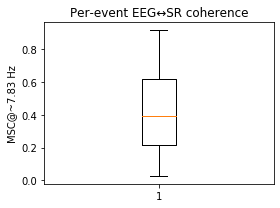


=== Ignition Detection — Session Summary ===
SR reference: EEG.AF8
EEG channels (n=3): AF7, TP9, TP10
Detection band: 7.83±0.40 Hz; z-thresh=3.00; window=5.0s; min_ISI=3.0s
R(t) band: 7.7–7.9 Hz, win=1.00s, step=0.25s

Events detected: 22
  zR max                 — median [IQR]: 4.14 [3.68, 4.96]
  zR peak (±5s)          — median [IQR]: 1.18 [1.18, 1.18]
  MSC@~7.83 Hz           — median [IQR]: 0.39 [0.21, 0.62]
  Coverage of recording  — 7.33%
  ETA zR peak            — 0.47 at 5.00s

Events by MSC@~7.83 Hz:
   t_start       t_end     msc_7p83   zR_max   zR_peak_±5s
 1716.712678  1728.401251  0.502563  9.460591   1.182891  
 1156.011439  1170.928001  0.024441  7.549796   1.179259  
  820.012228   825.012228  0.802892  5.688249   1.183502  
 1130.722058  1135.722058  0.378180  5.617844   1.182489  
  740.546938   745.546938  0.328092  5.304394   1.182680  
 1761.022034  1766.022034  0.112145  4.976429        NaN  
 1294.227201  1299.227201  0.663546  4.920622   1.177958  
 1641.943570

In [13]:
MUSE_ELECTRODES = ['EEG.AF7','EEG.TP9','EEG.TP10']

# ==========================================
# Batch ignition detection over many sessions
# ==========================================
import os
import pandas as pd
import numpy as np
import traceback

# 1) List your input files (CSV paths)
files = [
    # 'data/test.csv',
    'data/Muse-461E_2019-11-28--16-01-03_1575083390915.csv',
    'data/Muse-461E_2019-11-27--19-26-58_1575321084010.csv',
    'data/Muse-461E_2019-12-03--12-47-46_1575407413023.csv',
    'data/Muse-461E_2019-11-20--21-13-30_1574381977511.csv',
    'data/Muse-461E_2019-12-03--20-53-25_1575436553405.csv',
    'data/Muse-461E_2019-12-04--12-05-39_1575491284751.csv',
    'data/Muse-461E_2019-12-05--12-17-34_1575579123713.csv',
    'data/Muse-461E_2019-12-06--14-36-37_1575672417939.csv',
    'data/Muse-461E_2019-12-06--20-54-24_1575694700892.csv',
    'data/Muse-461E_2019-12-06--20-57-59_1575694836983.csv',
    'data/Muse-461E_2019-12-06--21-00-26_1575696038038.csv',
    'data/Muse-461E_2019-12-07--13-11-51_1575754159523.csv',
    'data/Muse-461E_2019-12-07--18-28-16_1575772914160.csv',
    'data/Muse-461E_2019-12-15--15-20-11_1576454995317.csv',
    'data/Muse-357D_2019-12-17--14-20-44_1576623304487.csv'
#     'data/Muse-357D_2019-12-24--10-52-16_1577215680302.csv',
#     'data/Muse-461E_2020-07-12--13-30-04_1594576299757.csv'
]

# 2) Output root for all sessions
ROOT_OUT = 'exports_ignitions_batch'
os.makedirs(ROOT_OUT, exist_ok=True)

# 4) Collect per-session summaries
master_rows = []

for fpath in files:
    muse_records = load_eeg_csv(fpath, electrodes=MUSE_ELECTRODES,device='muse')
    muse_records = muse_records.iloc[3840:-3840].reset_index(drop=True).copy()
    
    
    session_name = os.path.splitext(os.path.basename(fpath))[0]
    out_dir = os.path.join(ROOT_OUT, session_name)
    try:
        print(f"\n=== Processing {session_name} ===")
        
        out = detect_ignitions_session(
            muse_records,
            sr_channel="EEG.AF8",
            eeg_channels=MUSE_ELECTRODES,
            out_dir='exports_ignitions_batch/S01',
            center_hz=7.83, half_bw_hz=0.4,
            z_thresh=3, min_isi_sec=3, window_sec=5,
            R_band=(7.73,7.9), R_win_sec=1, R_step_sec=0.25,
            eta_pre_sec=5, eta_post_sec=5,
            show=True,
            verbose=True     # <--- prints the summary block
        )


        # Store summary row
        summ = out['summary'].copy()
        summ['session'] = session_name[:30]+" ..."
        summ['n_events'] = summ.get('n_events', 0)
        master_rows.append(summ)

    except Exception as e:
        print(f"[ERROR] {session_name}: {e}")
        traceback.print_exc()
        # add a failed row so you keep the log complete
        master_rows.append({'session': session_name[:15]+" ...", 'n_events': np.nan, 'error': str(e)})

# 5) Save master summary across sessions
master_df = pd.DataFrame(master_rows)
master_csv = os.path.join(ROOT_OUT, 'master_ignition_summary-MUSE.csv')
master_df.to_csv(master_csv, index=False)

print("\n=== Batch complete ===")
print("Master summary saved to:", master_csv)
print(master_df.fillna('').to_string(index=False))


In [14]:
# ---------- FAST ignition detector (surrogate-free, O(N)) ----------
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import signal

def _mkdir(p): 
    if p and not os.path.exists(p): os.makedirs(p, exist_ok=True); 
    return p

def ensure_timestamp_column(df, time_col='Timestamp', default_fs=128.0):
    if time_col in df.columns:
        s = df[time_col]
        if np.issubdtype(s.dtype, np.datetime64) or 'datetime' in str(s.dtype).lower():
            t = (pd.to_datetime(s)-pd.to_datetime(s).iloc[0]).dt.total_seconds().astype(float)
            df[time_col] = t.values; return time_col
        sn = pd.to_numeric(s, errors='coerce').astype(float)
        if sn.notna().sum()>max(50,0.5*len(df)):
            sn = sn - np.nanmin(sn[np.isfinite(sn)]); df[time_col]=sn.values; return time_col
    df[time_col] = np.arange(len(df), dtype=float)/default_fs; return time_col

def infer_fs(df, time_col='Timestamp'):
    t = np.asarray(pd.to_numeric(df[time_col], errors='coerce').values, float)
    dt = np.diff(t); dt = dt[(dt>0)&np.isfinite(dt)]
    if dt.size==0: raise ValueError('Cannot infer fs')
    return float(1.0/np.median(dt))

def get_series(df, name):
    if name in df.columns:
        return pd.to_numeric(df[name], errors='coerce').fillna(0.0).values.astype(float)
    alt = 'EEG.'+name
    if alt in df.columns:
        return pd.to_numeric(df[alt], errors='coerce').fillna(0.0).values.astype(float)
    raise ValueError(f'{name} not found')

def band_hilbert(x, fs, f0, half=0.6, order=4):
    ny=0.5*fs; lo=max(0.01, f0-half); hi=min(f0+half, 0.999*ny)
    b,a = signal.butter(order, [lo/ny, hi/ny], btype='band')
    xb = signal.filtfilt(b,a,x)
    z  = signal.hilbert(xb)
    return z  # complex analytic narrowband

def running_mean(x, N):
    # convolution with ones, 'same' length
    return np.convolve(x, np.ones(N, dtype=float), mode='same')/float(N)

def robust_z(x):
    x = np.asarray(x, float)
    med = np.nanmedian(x); mad = np.nanmedian(np.abs(x-med)); scale = 1.4826*(mad+1e-12)
    return (x - med)/scale

def detect_ignitions_fast(
    RECORDS, eeg_channel, sr_channel, *,
    time_col='Timestamp',
    f0=7.83, half_bw=0.6,
    win_sec=3.0, step_sec=0.25,
    thr_pct=99.0,                      # threshold on baseline quantile of score S
    baseline_windows=None,             # [(t0,t1),...] used for threshold; if None -> whole
    min_consec=2, merge_gap_sec=0.4, min_dur_sec=0.2,
    out_dir='exports_ignitions_fast', show=True
):
    _mkdir(out_dir)
    ensure_timestamp_column(RECORDS, time_col=time_col)
    fs = infer_fs(RECORDS, time_col)
    ny = 0.5*fs
    if f0 >= ny: raise ValueError('f0 must be < Nyquist')

    x = get_series(RECORDS, eeg_channel)
    s = get_series(RECORDS, sr_channel)

    # ---- single-pass narrowband analytic signals ----
    ze = band_hilbert(x, fs, f0, half_bw)
    zs = band_hilbert(s, fs, f0, half_bw)
    amp_e2 = np.abs(ze)**2
    amp_s2 = np.abs(zs)**2
    cross  = ze * np.conj(zs)                # complex cross term
    dphi_u = np.exp(1j*(np.angle(ze) - np.angle(zs)))  # unit phase-diff vector

    # ---- sliding window stats via running means ----
    Nw   = int(round(win_sec * fs))
    if Nw < 16: Nw = 16
    step = int(max(1, round(step_sec * fs)))

    E_cross = running_mean(cross,  Nw)        # ~E[z_e z_s*]
    E_ae    = running_mean(amp_e2, Nw)        # ~E[|z_e|^2]
    E_as    = running_mean(amp_s2, Nw)        # ~E[|z_s|^2]
    # MSC-like coherence (fast narrowband approximation)
    msc     = np.abs(E_cross)**2 / (E_ae*E_as + 1e-20)

    # H-PLI via running mean of unit phasors
    E_re = running_mean(np.real(dphi_u), Nw)
    E_im = running_mean(np.imag(dphi_u), Nw)
    hpli = np.sqrt(E_re**2 + E_im**2)

    # sample the traces every 'step' samples to get centers
    idx   = np.arange(Nw//2, len(x)-Nw//2, step, dtype=int)
    tcent = pd.to_numeric(RECORDS[time_col]).values[idx]

    msc_s = np.clip(np.real(msc[idx]), 0.0, 1.0)
    hpl_s = np.clip(hpli[idx], 0.0, 1.0)

    # score & threshold
    S = robust_z(msc_s) + robust_z(hpl_s)

    if baseline_windows:
        mask = np.zeros_like(S, dtype=bool)
        for (t0,t1) in baseline_windows:
            mask |= (tcent >= t0) & (tcent <= t1)
        if not np.any(mask): mask = np.ones_like(S, bool)
    else:
        mask = np.ones_like(S, bool)

#     thr = float(np.nanpercentile(S[mask], thr_pct))

    # ---- robust calibration options ----
    # 1) Percentile (as before)
    thr_pct_val = float(np.nanpercentile(S[mask], thr_pct))

    # 2) MAD-based z threshold (for when percentiles don't move enough)
    S_base = S[mask]
    med = float(np.nanmedian(S_base))
    mad = float(np.nanmedian(np.abs(S_base - med))) + 1e-12
    zK  = 2.5   # <- tune: 1.5 (looser) … 3.5 (stricter)

    thr_mad = med + zK * 1.4826 * mad

    # 3) Final threshold = max of the two, with an optional scale factor
    scale = 1.00  # <- tune: <1 lowers (more hits), >1 raises (fewer hits)
    thr = scale * max(thr_pct_val, thr_mad)

    # detect runs above threshold
    above = np.isfinite(S) & (S > thr)
    events=[]
    if np.any(above):
        hits = np.where(above)[0]
        brk  = np.where(np.diff(hits) > 1)[0]
        starts = np.r_[hits[0], hits[brk+1]]
        stops  = np.r_[hits[brk], hits[-1]]
        # merge close runs by time gap
        merged=[]
        for a,b in zip(starts, stops):
            if not merged: merged.append([a,b])
            else:
                last_a, last_b = merged[-1]
                gap = (tcent[a] - tcent[last_b])
                if gap <= merge_gap_sec:
                    merged[-1][1] = b
                else:
                    merged.append([a,b])
        # enforce min_consec and compute metrics
        for a,b in merged:
            if (b - a + 1) < min_consec: 
                continue
            t0 = tcent[a] - 0.5*win_sec
            t1 = tcent[b] + 0.5*win_sec
            dur = max(0.0, t1 - t0)
            if dur < min_dur_sec: 
                continue
            seg = slice(a, b+1)
            events.append({
                't_start': float(t0),
                't_stop':  float(t1),
                'duration_s': float(dur),
                'S_peak': float(np.nanmax(S[seg])),
                'S_mean': float(np.nanmean(S[seg])),
                'msc_peak': float(np.nanmax(msc_s[seg])),
                'hpli_peak': float(np.nanmax(hpl_s[seg]))
            })
    events_df = pd.DataFrame(events)

    # ---- save plots & CSV (fast, robust) ----
    _mkdir(out_dir)

    # Score trace
    plt.figure(figsize=(10,3.4))
    plt.plot(tcent, S, lw=1.2, label='Score S (z)')
    plt.axhline(thr, color='k', ls='--', lw=1.0, label=f'P{thr_pct:.1f} baseline')
    for _,ev in events_df.iterrows():
        plt.axvspan(ev['t_start'], ev['t_stop'], color='k', alpha=0.08)
    plt.xlabel('Time (s)'); plt.ylabel('Score'); plt.title('Ignition score (fast) & events')
    plt.legend(loc='upper right', fontsize=8); plt.grid(True, alpha=0.25, linestyle=':')
    plt.tight_layout(); _mkdir(out_dir); _safe_savefig(os.path.join(out_dir, 'fast_ignition_score.png'))
    if show: plt.show()
    plt.close()

    # Summary bar if any events
    if not events_df.empty:
        plt.figure(figsize=(8,3.0))
        plt.bar(np.arange(len(events_df)), events_df['S_peak'].values, width=0.7)
        plt.xlabel('event id'); plt.ylabel('S_peak'); plt.title('Ignition peaks (fast)')
        plt.tight_layout(); _safe_savefig(os.path.join(out_dir, 'fast_ignition_peaks.png'))
        if show: plt.show()
        plt.close()

    # CSV
    out_csv = os.path.join(out_dir, 'fast_ignition_events.csv')
    events_df.to_csv(out_csv, index=False)

    return {
        'events': events_df,
        'score_trace': pd.DataFrame({'t_center_s': tcent, 'S': S, 'thr': thr, 'msc': msc_s, 'hpli': hpl_s}),
        'paths': {
            'score_png': os.path.join(out_dir, 'fast_ignition_score.png'),
            'peaks_png': os.path.join(out_dir, 'fast_ignition_peaks.png') if not events_df.empty else None,
            'events_csv': out_csv
        }
    }



NameError: name '_safe_savefig' is not defined

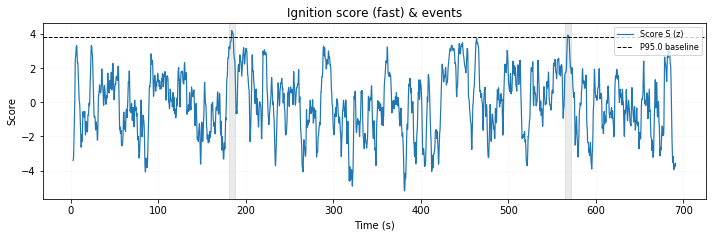

In [15]:
out = detect_ignitions_fast(
    RECORDS,
    eeg_channel='EEG.O1',     # or 'EEG.O1'
    sr_channel='EEG.F4',        # or magnetometer
    f0=7.83, half_bw=0.6,
    win_sec=5, step_sec=0.25,      # <— short windows, small step
    thr_pct=95,                    # try 98.0 for more hits, 99.5 to be stricter
    baseline_windows=[(100,160)],  # optional; improves thresholding
    min_consec=2, merge_gap_sec=0.4, min_dur_sec=0.2,
    out_dir='exports_ignitions_fast', show=True
)
out['events']
